# make annotations bed files. 

**Scope:** protein coding genes

**Source:** Gencode V31 hg38 GTF `gencode.v31.primary_assembly.annotation.pandas.df.txt`


In [59]:
options(repr.plot.width=20, repr.plot.height=8)

In [11]:
library(parallel)

In [12]:
parallel::detectCores()

[1] 40

In [13]:
library(tidyverse)
library(naturalsort)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [14]:
library(GenomicRanges)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,

In [15]:
library(tictoc)

In [16]:
flatui = c("#9b59b6", "#3498db", "#004F99", "#250352", "#95a5a6", "#e74c3c", "#ECE59A", "#34495e", "#2ecc71", "#5B9E00", "#A71812")

In [17]:
setwd("/c/groups/sanjana_lab/cdai/TFscreen/atac/annotations")

In [5]:
gencode_gtf <- read.table("/c/groups/sanjana_lab/cdai/ref_genome/gencode.v31.primary_assembly.annotation.pandas.df.txt", header=T, sep="\t", stringsAsFactors=F)

#### Gene features:

- Enhancer: [TSS - 10kb, TSS - 2kb]
- TSS: [TSS - 2kb, TSS + 1kb]
- UTR: include both 5' and 3' UTR. 
- Exon:
- Intron: None intron. [gene - union(exon + utr).]

In [6]:
gencode_gtf %>% filter(gene_type == "protein_coding" & source == "HAVANA" & feature == "UTR") %>% 
    select(seqname, source, feature, start, end, strand, hgnc_symbol) %>% 
    group_by(hgnc_symbol) %>% head(2)

ERROR: Error in gencode_gtf %>% filter(gene_type == "protein_coding" & source == : could not find function "%>%"


In [ ]:
# get list of all protein coding genes (selecting HAVANA only)
gene.list <- gencode_gtf %>% filter(gene_type == "protein_coding" & source == "HAVANA" & feature == "gene") %>% select(hgnc_symbol) %>% pull(hgnc_symbol) %>% unique

In [ ]:
gencode_gtf %>% filter(gene_type == "protein_coding" & source == "HAVANA" & hgnc_symbol == "ZBTB18") %>% 
    select(seqname, source, feature, start, end, strand, hgnc_symbol) %>% arrange(start)
    #filter(feature == "gene" | feature == "transcript")

In [34]:
getFeatureRange <- function(gene, gtf_df) {
    # get gene overall (directly from GENCODE)
    gene.range <- gtf_df %>% filter(gene_type == "protein_coding" & source == "HAVANA" & hgnc_symbol == gene & feature == "gene") %>% 
                    select(seqname, start, end, feature, strand, hgnc_symbol) %>%
                    makeGRangesFromDataFrame(., keep.extra.columns = T)
    
    # get exons (directly from GENCODE)
    exon.range <- gtf_df %>% filter(gene_type == "protein_coding" & source == "HAVANA" & hgnc_symbol == gene & feature == "exon") %>% 
                    select(seqname, start, end, feature, strand, hgnc_symbol) %>%
                    arrange(start) %>%
                    makeGRangesFromDataFrame(., keep.extra.columns = T)
    # get utr (directly from GENCODE)
    utr.range <- gtf_df %>% filter(gene_type == "protein_coding" & source == "HAVANA" & hgnc_symbol == gene & feature == "UTR") %>% 
                    select(seqname, start, end, feature, strand, hgnc_symbol) %>%
                    arrange(start) %>%
                    makeGRangesFromDataFrame(., keep.extra.columns = T)
    
    # get intron (gene.range - union(exon, utr))
    intron.range <- c(exon.range, utr.range) %>% setdiff(gene.range, .) %>% as.data.frame %>% 
                add_column(feature = "intron", hgnc_symbol = gene) %>%
                makeGRangesFromDataFrame(., keep.extra.columns = T)
    
    # get promoter region (TSS - 2kb, TSS + 500b)
    promoter.range <- promoters(gene.range, upstream = 2000, downstream = 1000)
    promoter.range$feature <- "promoter"
    
    # get enhancer region (TSS - 10kb, TSS - 2001b)
    enhancer.range <- flank(promoter.range, width = 8000, start = T)
    enhancer.range$feature <- "enhancer"

    values <- list("gene" = as.data.frame(gene.range), 
                "exon" = as.data.frame(exon.range), 
                "utr" = as.data.frame(utr.range), 
                "intron" = as.data.frame(intron.range), 
                "promoter" = as.data.frame(promoter.range), 
                "enhancer" = as.data.frame(enhancer.range))
    values <- do.call(rbind, values)
}

In [35]:
gene.feature.df <- data.table::rbindlist(gene.feature.list)

ERROR: Error in data.table::rbindlist(gene.feature.list): object 'gene.feature.list' not found


In [ ]:
getwd()

In [ ]:
# read in gene features
gene.feature.df <- read.table("Gencode_hg38_v31_proteincoding_gene_features_20200108.txt", sep="\t", header=T, stringsAsFactors=F)

In [ ]:
# convert gene feature text file to a bed file, by selecting fields
gene.feature.df %>% 
        select(seqnames, start, end, feature, hgnc_symbol, strand) %>% 
        filter(feature != "gene") %>%
        write.table(., file = "Gencode_hg38_v31_proteincoding_gene_features.bed", quote = F, sep = "\t", row.names = F, col.names = F)

In [ ]:
gene.feature.df$feature %>% unique

#### TSS coordinates

In [87]:
# all Protein coding gene TSS
tss <- gencode_gtf %>% filter(gene_type == "protein_coding" & source == "HAVANA" & feature == "gene") %>% 
                    select(seqname, start, end, feature, strand, hgnc_symbol) %>%
                    makeGRangesFromDataFrame(keep.extra.columns = T, ignore.strand = F) %>%
                    promoters(0,2)

In [102]:
# Write Hit TF TSS bed file
tss %>% as.data.frame %>% 
    select(seqnames, start, end, hgnc_symbol, strand) %>%
    filter(hgnc_symbol %in% hitlist) %>%
    add_column("score"=1, .before = "strand") %>%
    write.table(file = "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/meta_analysis/HitTF.tss.bed", 
                quote = F, sep = "\t", row.names = F, col.names = F)

In [107]:
# Write NON Hit TF TSS bed file
tss %>% as.data.frame %>% 
    select(seqnames, start, end, hgnc_symbol, strand) %>%
    filter(hgnc_symbol %in% setdiff(tflist, hitlist)) %>%
    add_column("score"=1, .before = "strand") %>%
    write.table(file = "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/meta_analysis/NonHitTF.tss.bed", 
                quote = F, sep = "\t", row.names = F, col.names = F)

### Gene body coordinates

In [110]:
gene_body <- gencode_gtf %>% filter(gene_type == "protein_coding" & source == "HAVANA" & feature == "gene") %>% 
                    select(seqname, start, end, feature, strand, hgnc_symbol) %>%
                    makeGRangesFromDataFrame(keep.extra.columns = T, ignore.strand = F)

In [113]:
gene_body %>% as.data.frame %>% 
            select(seqnames, start, end, hgnc_symbol, strand) %>%
            filter(hgnc_symbol %in% hitlist) %>%
            add_column("score"=1, .before = "strand") %>%
            write.table(file = "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/meta_analysis/HitTF.genebody.bed", 
                        quote = F, sep = "\t", row.names = F, col.names = F)

In [114]:
gene_body %>% as.data.frame %>% 
            select(seqnames, start, end, hgnc_symbol, strand) %>%
            filter(hgnc_symbol %in% setdiff(tflist, hitlist)) %>%
            add_column("score"=1, .before = "strand") %>%
            write.table(file = "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/meta_analysis/NonHitTF.genebody.bed", 
                        quote = F, sep = "\t", row.names = F, col.names = F)

### Promoter coordinates (TSS upstream 2kb, downstream 2kb)

In [119]:
promo <- gencode_gtf %>% filter(gene_type == "protein_coding" & source == "HAVANA" & feature == "gene") %>% 
                    select(seqname, start, end, feature, strand, hgnc_symbol) %>%
                    makeGRangesFromDataFrame(keep.extra.columns = T, ignore.strand = F) %>%
                    promoters(2000,2000) 

In [120]:
promo %>% as.data.frame %>% 
            select(seqnames, start, end, hgnc_symbol, strand) %>%
            filter(hgnc_symbol %in% hitlist) %>%
            add_column("score"=1, .before = "strand") %>%
            write.table(file = "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/meta_analysis/HitTF.promoter_up2k_dn2k.bed", 
                        quote = F, sep = "\t", row.names = F, col.names = F)

In [121]:
promo %>% as.data.frame %>% 
            select(seqnames, start, end, hgnc_symbol, strand) %>%
            filter(hgnc_symbol %in% setdiff(tflist, hitlist)) %>%
            add_column("score"=1, .before = "strand") %>%
            write.table(file = "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/meta_analysis/NonHitTF.promoter_up2k_dn2k.bed", 
                        quote = F, sep = "\t", row.names = F, col.names = F)

In [510]:
gene.feature.df %>% filter(feature == "promoter") %>%
        select(seqnames, start, end, hgnc_symbol, strand) %>% 
        add_column("score"=1, .before = "strand") %>%
        write.table(., file = "Gencode_hg38_v31_proteincoding_promoter_up2k_dn1kb.bed", quote = F, sep = "\t", row.names = F, col.names = F)

In [512]:
gene.feature.df %>% filter(feature == "promoter" & hgnc_symbol %in% hitlist) %>%
        select(seqnames, start, end, hgnc_symbol, strand) %>% 
        add_column("score"=1, .before = "strand") %>%
        write.table(., file = "hitTF_promoter_up2k_dn1kb.bed", quote = F, sep = "\t", row.names = F, col.names = F)

In [516]:
gene.feature.df %>% filter(feature == "promoter" & hgnc_symbol %in% nonHitlist) %>%
        select(seqnames, start, end, hgnc_symbol, strand) %>% 
        add_column("score"=1, .before = "strand") %>%
        write.table(., file = "nonHitTF_promoter_up2k_dn1kb.bed", quote = F, sep = "\t", row.names = F, col.names = F)

In [498]:
gene.feature.df %>% 
        select(seqnames, start, end, feature, hgnc_symbol, strand) %>% 
        filter(feature == "gene") %>% 
        write.table(., file = "Gencode_hg38_v31_proteincoding_genebody.bed", quote = F, sep = "\t", row.names = F, col.names = F)

### bedtools to intersect peaks with annotations

script: `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/macs2/v7/annotate_peaks.sh`

results: 
`/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/macs2/v7/annotate_peaks_w_features/ATAC*_peaks_annotated`

### peak analysis

In [18]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/macs2/v7/annotate_peaks_w_features/")

In [19]:
figure_dir <- "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/figures"

In [37]:
# Get peak file names and natural sort the names
peak_files <- dir(".", pattern="peaks_annotated.bed") %>% .[naturalorder(.)]

# Read in all peak files into dataframe
peak_cols <- c("chrom", "chromStart", "chromEnd", "name", "score", "strand", 
               "signalValue", "pValue", "qValue", "peak", "chromB", "chromStartB", "chromEndB", "feature", "gene", "strandB")
peak.ls <- map(peak_files, ~ read.table(.x, header = F, sep = "\t", stringsAsFactors=F, col.names=peak_cols))
names(peak.ls) <- map_chr(peak_files, ~ if (str_detect(.x, pattern="ATAC([\\d]_)")) x = str_replace(.x, "ATAC", "ATAC0") else x = .x) %>% 
                            map_chr(., ~str_replace(.x, "_peaks_annotated.bed", ""))

In [38]:
#120 hit list
hitlist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/Hitlist_20191230.csv', header = T, stringsAsFactors = F) %>% pull(hgnc_symbol)
#TF list
tflist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/TFlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)

In [39]:
# Add ishit, istf columns, transform "." & "enhancer" features to "intergenic"
peak.ls <- map(peak.ls, ~ mutate(.x, is_hit = if_else(gene %in% hitlist, TRUE, FALSE))) %>%
            map(., ~ mutate(.x, is_tf = if_else(gene %in% tflist, TRUE, FALSE))) %>%
            map(., ~ mutate_at(.x, .vars = "feature", 
                               .funs= ~ if_else(.x %in% c(".", "enhancer"), "intergenic", .x))) #renaming enhancer and unmapped to intergenic

In [40]:
names(peak.ls) %>% t

ATAC01,ATAC02,ATAC03,ATAC04,ATAC05,ATAC06,ATAC07,ATAC08,ATAC09,ATAC10,ATAC11,ATAC12


In [41]:
names(peak.ls) <- factor(c("ES_1", "ES_2", "H1_1", "H1_2", "H4_1", "H4_2", "H16_1", "H16_2", "H24_1", "H24_2", "D5_1", "D5_2"), 
                         levels = c("ES_1", "ES_2", "H1_1", "H1_2", "H4_1", "H4_2", "H16_1", "H16_2", "H24_1", "H24_2", "D5_1", "D5_2"))
peak.ls <- map2(peak.ls, names(peak.ls), ~ mutate(.x, sample = .y)) # add sample name column

### Number of peaks per time point per feature
#### genome wide

In [42]:
sample_levels <- factor(c("ES_1", "ES_2", "H1_1", "H1_2", "H4_1", "H4_2", "H16_1", "H16_2", "H24_1", "H24_2", "D5_1", "D5_2"), 
                         levels = c("ES_1", "ES_2", "H1_1", "H1_2", "H4_1", "H4_2", "H16_1", "H16_2", "H24_1", "H24_2", "D5_1", "D5_2"))

feature_levels <- factor(c("intergenic", "intron", "exon", "UTR", "promoter"), 
                         levels = c("intergenic", "intron", "exon", "UTR", "promoter"))

In [43]:
peak.sum.gw <- map_df(peak.ls, rbind) %>% group_by(sample, feature) %>% 
                summarise(n_distinct(name)) %>% 
                mutate_at(., .vars = "feature", .funs = ~ factor(.x, levels = feature_levels)) %>%
                rename(`n_distinct(name)` = "peaknum") %>% ungroup %>%
                mutate_at(., .vars = "sample", ~ factor(.x, sample_levels))

In [44]:
# removing intergenic features
peak.sum.gw <- filter(peak.sum.gw, feature != "intergenic")

In [45]:
flatui

[1] "#9b59b6" "#3498db" "#004F99" "#250352" "#95a5a6" "#e74c3c" "#ECE59A"
 [8] "#34495e" "#2ecc71" "#5B9E00" "#A71812"

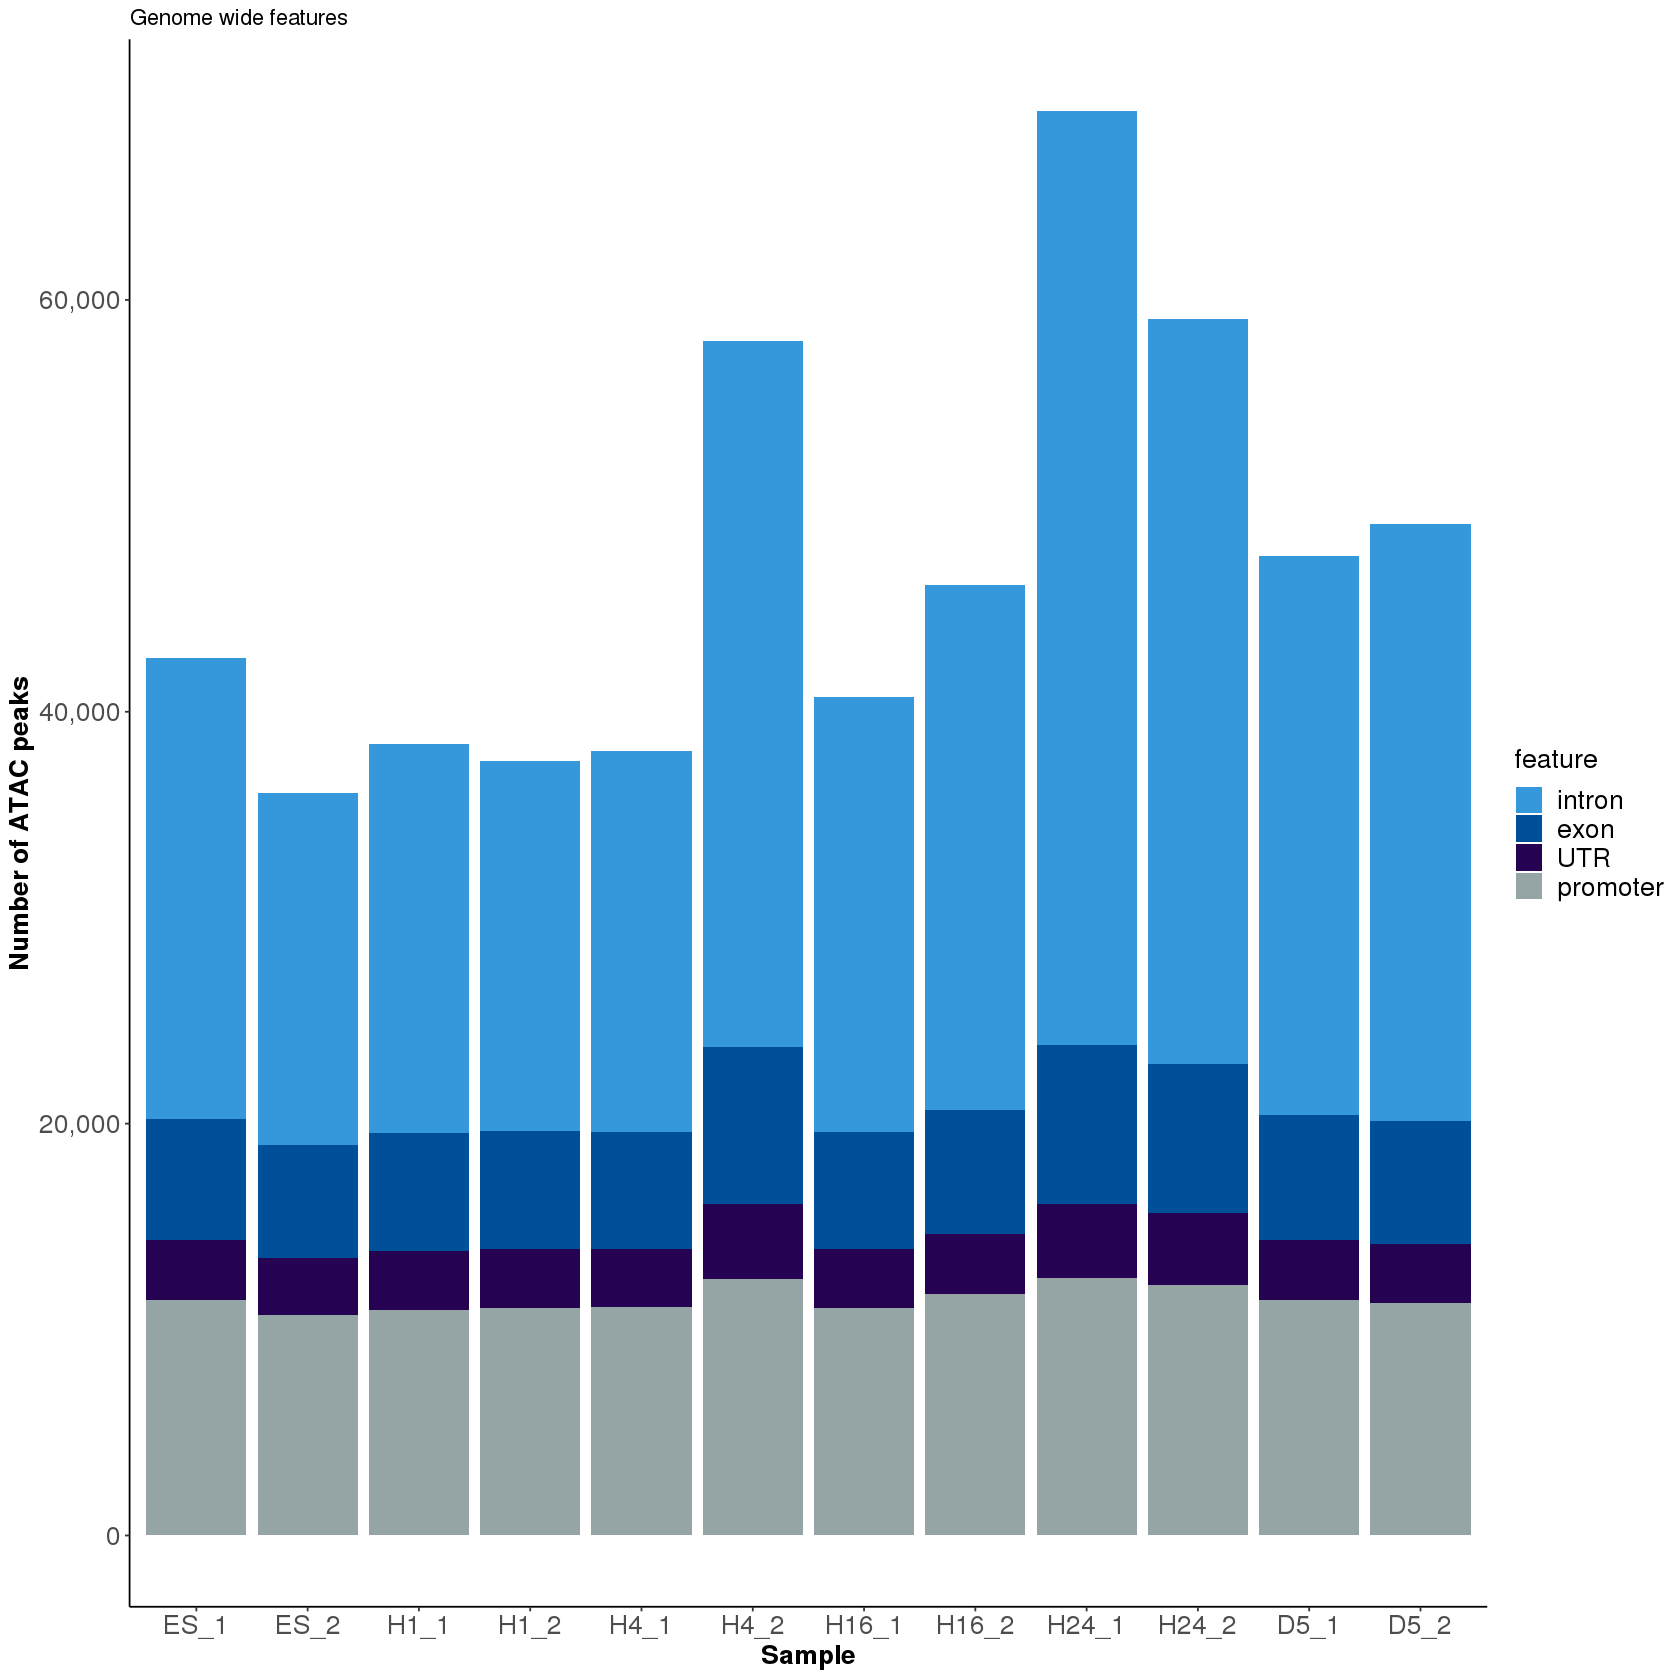

In [46]:
ggplot(peak.sum.gw) + geom_bar(aes(x = sample, y = peaknum, fill = feature), stat = "identity") + 
                labs(title = "Genome wide features") + 
                xlab(label = "Sample") + 
                ylab(label = "Number of ATAC peaks") +
                theme_classic() +
                scale_fill_manual(values=c("intergenic" = flatui[1], 
                                           "intron"= flatui[2], 
                                           "exon" = flatui[3], 
                                           "UTR" = flatui[4], 
                                           "promoter" = flatui[5])) +
                scale_y_continuous(labels = scales::comma) +
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                      legend.text=element_text(size=16),legend.title=element_text(size=16))

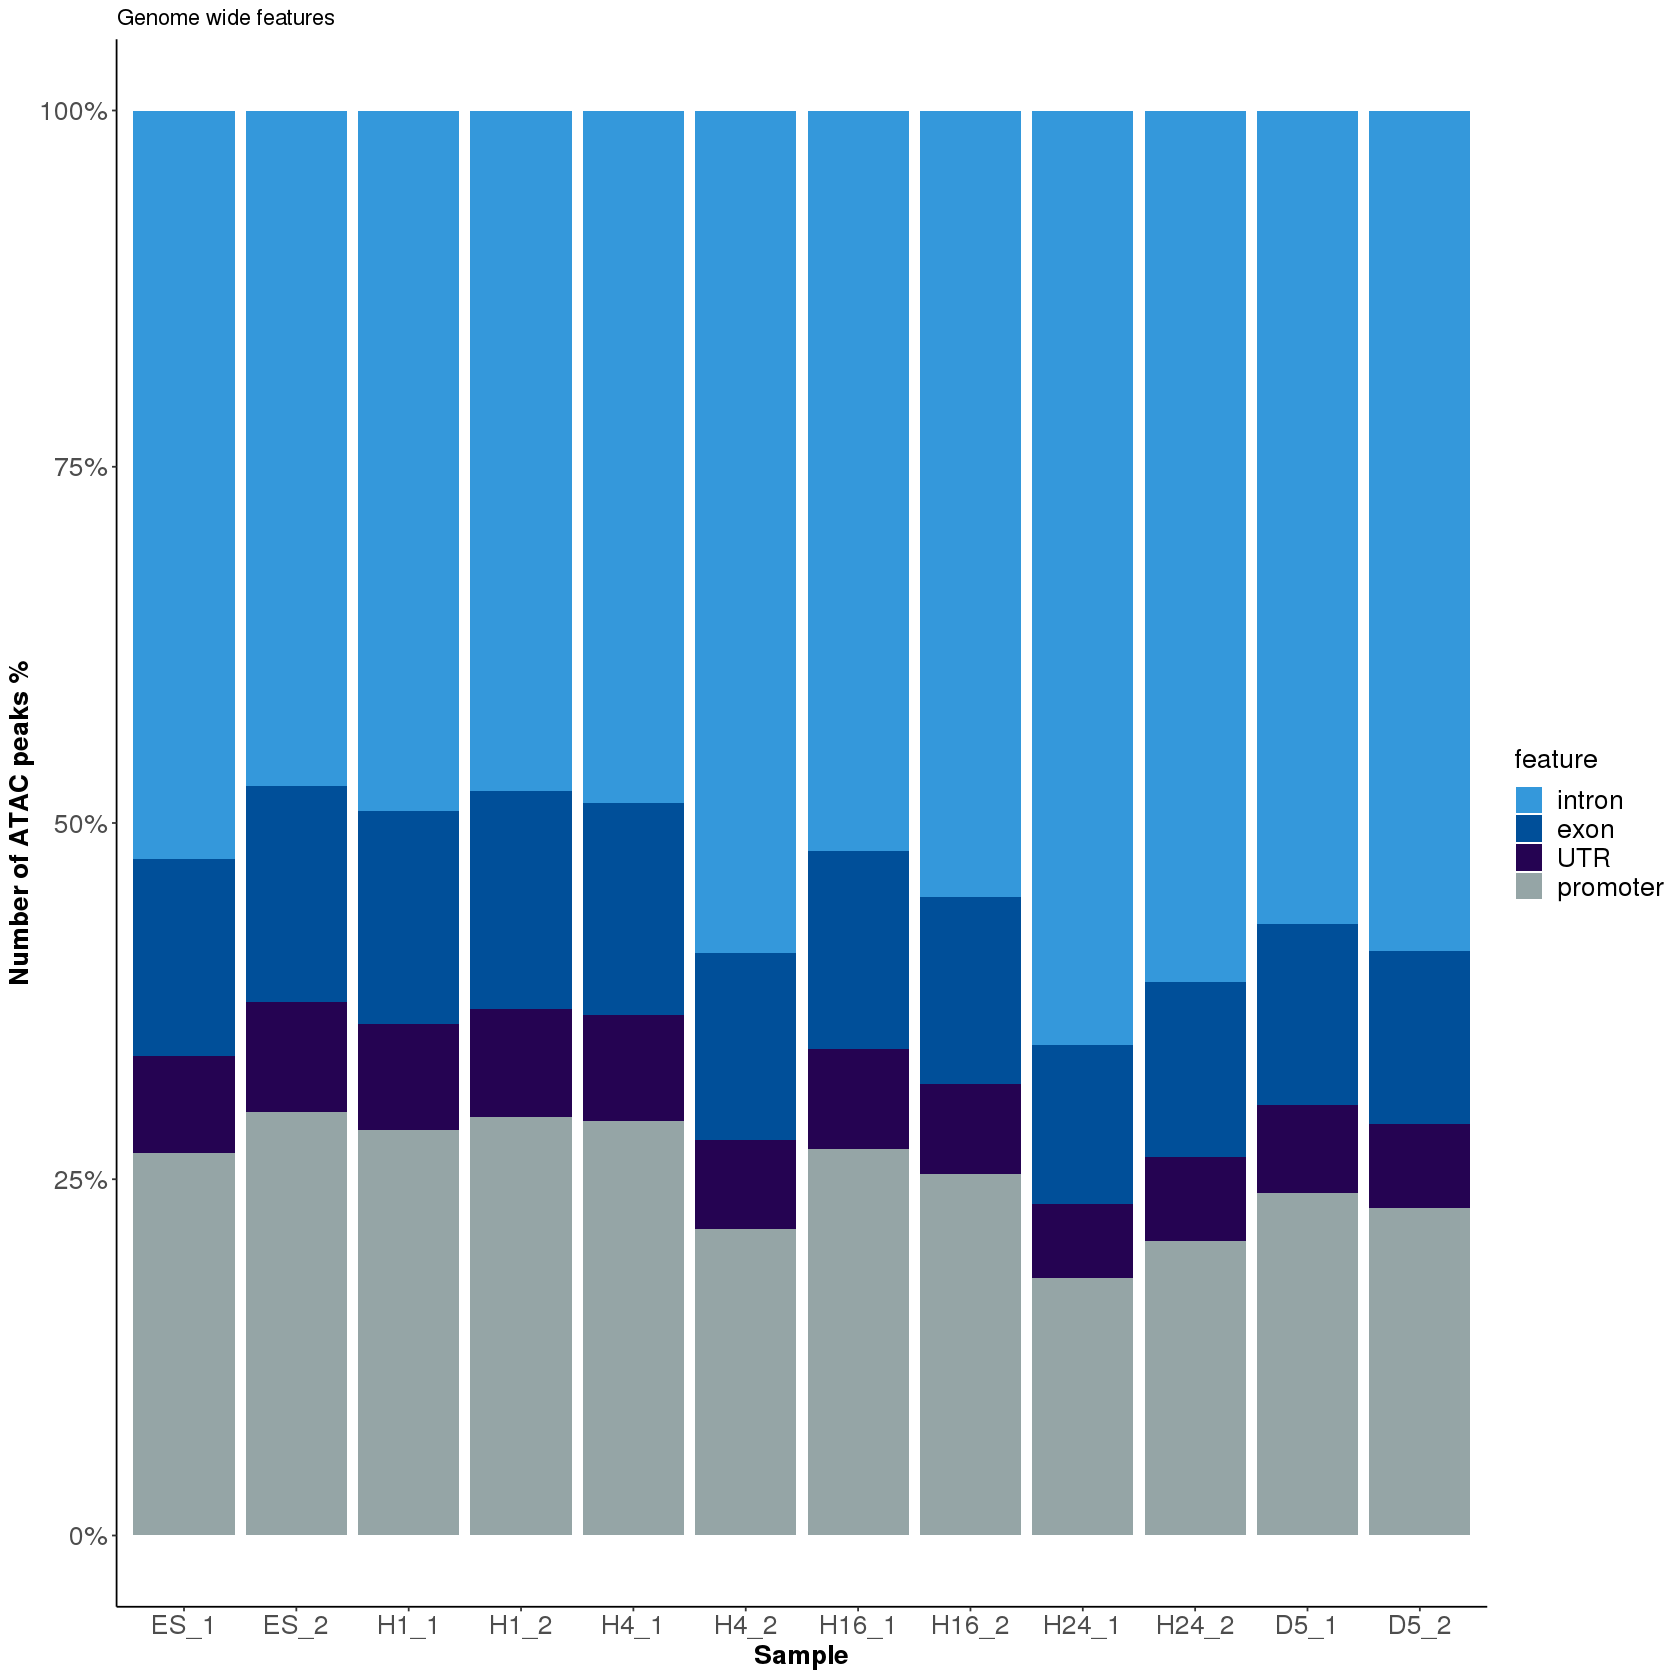

In [35]:
ggplot(peak.sum.gw) + geom_bar(aes(x = sample, y = peaknum, fill = feature), stat = "identity", position = "fill") + 
                labs(title = "Genome wide features") + 
                xlab(label = "Sample") + 
                ylab(label = "Number of ATAC peaks %") +
                theme_classic() +
                scale_fill_manual(values=c("intergenic" = flatui[1], 
                                           "intron"= flatui[2], 
                                            "exon" = flatui[3], 
                                           "UTR" = flatui[4], 
                                           "promoter" = flatui[5])) +
                scale_y_continuous(labels = scales::percent) +
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                      legend.text=element_text(size=16),legend.title=element_text(size=16))

In [380]:
# one way anova of intergenic / intron / exon / UTR / promoter ?

In [319]:
write.table(peak.sum.gw, file = file.path(figure_dir, "peak_summary_genomewide.txt"), quote=F, row.names=F, col.names=T)

In [233]:
write.table(peak.sum.tf, file = file.path(figure_dir, "peak_summary_TFs.txt"), quote=F, row.names=F, col.names=T)

### Hit TFs

In [47]:
# only plot Hit TFs
peak.sum.hits <- map_df(peak.ls, rbind) %>% filter(., is_hit) %>% 
                group_by(sample, feature) %>% 
                summarise(n_distinct(name)) %>%
                mutate_at(., .vars = "feature", .funs = ~ factor(.x, levels = feature_levels)) %>%
                rename(`n_distinct(name)` = "peaknum") %>% ungroup %>%
                mutate_at(., .vars = "sample", .funs = ~ factor(.x, levels = sample_levels))

In [48]:
peak.sum.hits <- filter(peak.sum.hits, feature != "intergenic")

In [49]:
color_scheme <- c("intergenic" = flatui[1], 
                  "intron"= flatui[3], 
                  "exon" = flatui[5], 
                  "UTR" = flatui[7], 
                  "promoter" = flatui[9])

In [50]:
gg.hits <- peak.sum.hits %>% ggplot(.) + geom_bar(aes(x = sample, y = peaknum, fill = feature), 
                                                  stat = "identity", position = "fill") + 
                theme_classic() + 
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                      legend.text=element_text(size=16),legend.title=element_text(size=16),
                    axis.text.x = element_text(angle = 45, hjust = 1)) +
                labs(title = "Hit TF features") + 
                xlab("Sample") + ylab("Peak %") +
                scale_fill_manual(values=color_scheme) +
                scale_y_continuous(labels = scales::percent)

In [51]:
gg.hits.2 <- peak.sum.hits %>% ggplot(.) + geom_bar(aes(x = sample, y = peaknum, fill = feature), 
                                                    stat = "identity") + 
                theme_classic() + 
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                      legend.text=element_text(size=16),legend.title=element_text(size=16),
                     axis.text.x = element_text(angle = 45, hjust = 1)) +
                labs(title = "Hit TF features") + 
                xlab("Sample") + ylab("Peaks") +
                scale_fill_manual(values=color_scheme) +
                scale_y_continuous(labels = scales::comma)

### Non-hit TFs

In [52]:
# only plot Non-Hit TFs
peak.sum.nonhits <- map_df(peak.ls, rbind) %>% filter(., !is_hit) %>% 
                group_by(sample, feature) %>% 
                summarise(n_distinct(name)) %>%
                mutate_at(., .vars = "feature", .funs = ~ factor(.x, levels = feature_levels)) %>%
                rename(`n_distinct(name)` = "peaknum") %>% ungroup %>%
                mutate_at(., .vars = "sample", .funs = ~ factor(.x, levels = sample_levels))

In [53]:
peak.sum.nonhits <- filter(peak.sum.nonhits, feature != "intergenic")

In [54]:
gg.nonhits <- peak.sum.nonhits %>% ggplot(.) + geom_bar(aes(x = sample, y = peaknum, fill = feature), stat = "identity", position = "fill") +
                theme_classic() + 
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                      legend.text=element_text(size=16),legend.title=element_text(size=16),
                      axis.text.x = element_text(angle = 45, hjust = 1)) +
                labs(title = "Non-Hit TF features") + 
                xlab("Sample") + ylab("Peak %") +
                scale_fill_manual(values=color_scheme) +
                scale_y_continuous(labels = scales::percent)
                

In [1]:
gg.nonhits.2 <- peak.sum.nonhits %>% ggplot(.) + geom_bar(aes(x = sample, y = peaknum, fill = feature), 
                                                          stat = "identity") + 
                theme_classic() + 
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                      legend.text=element_text(size=16),legend.title=element_text(size=16),
                      axis.text.x = element_text(angle = 45, hjust = 1)) +
                labs(title = "Non-Hit TF features") + 
                xlab("Sample") + ylab("Peaks") +
                scale_fill_manual(values=color_scheme) +
                scale_y_continuous(labels = scales::comma)

ERROR: Error in peak.sum.nonhits %>% ggplot(.): could not find function "%>%"


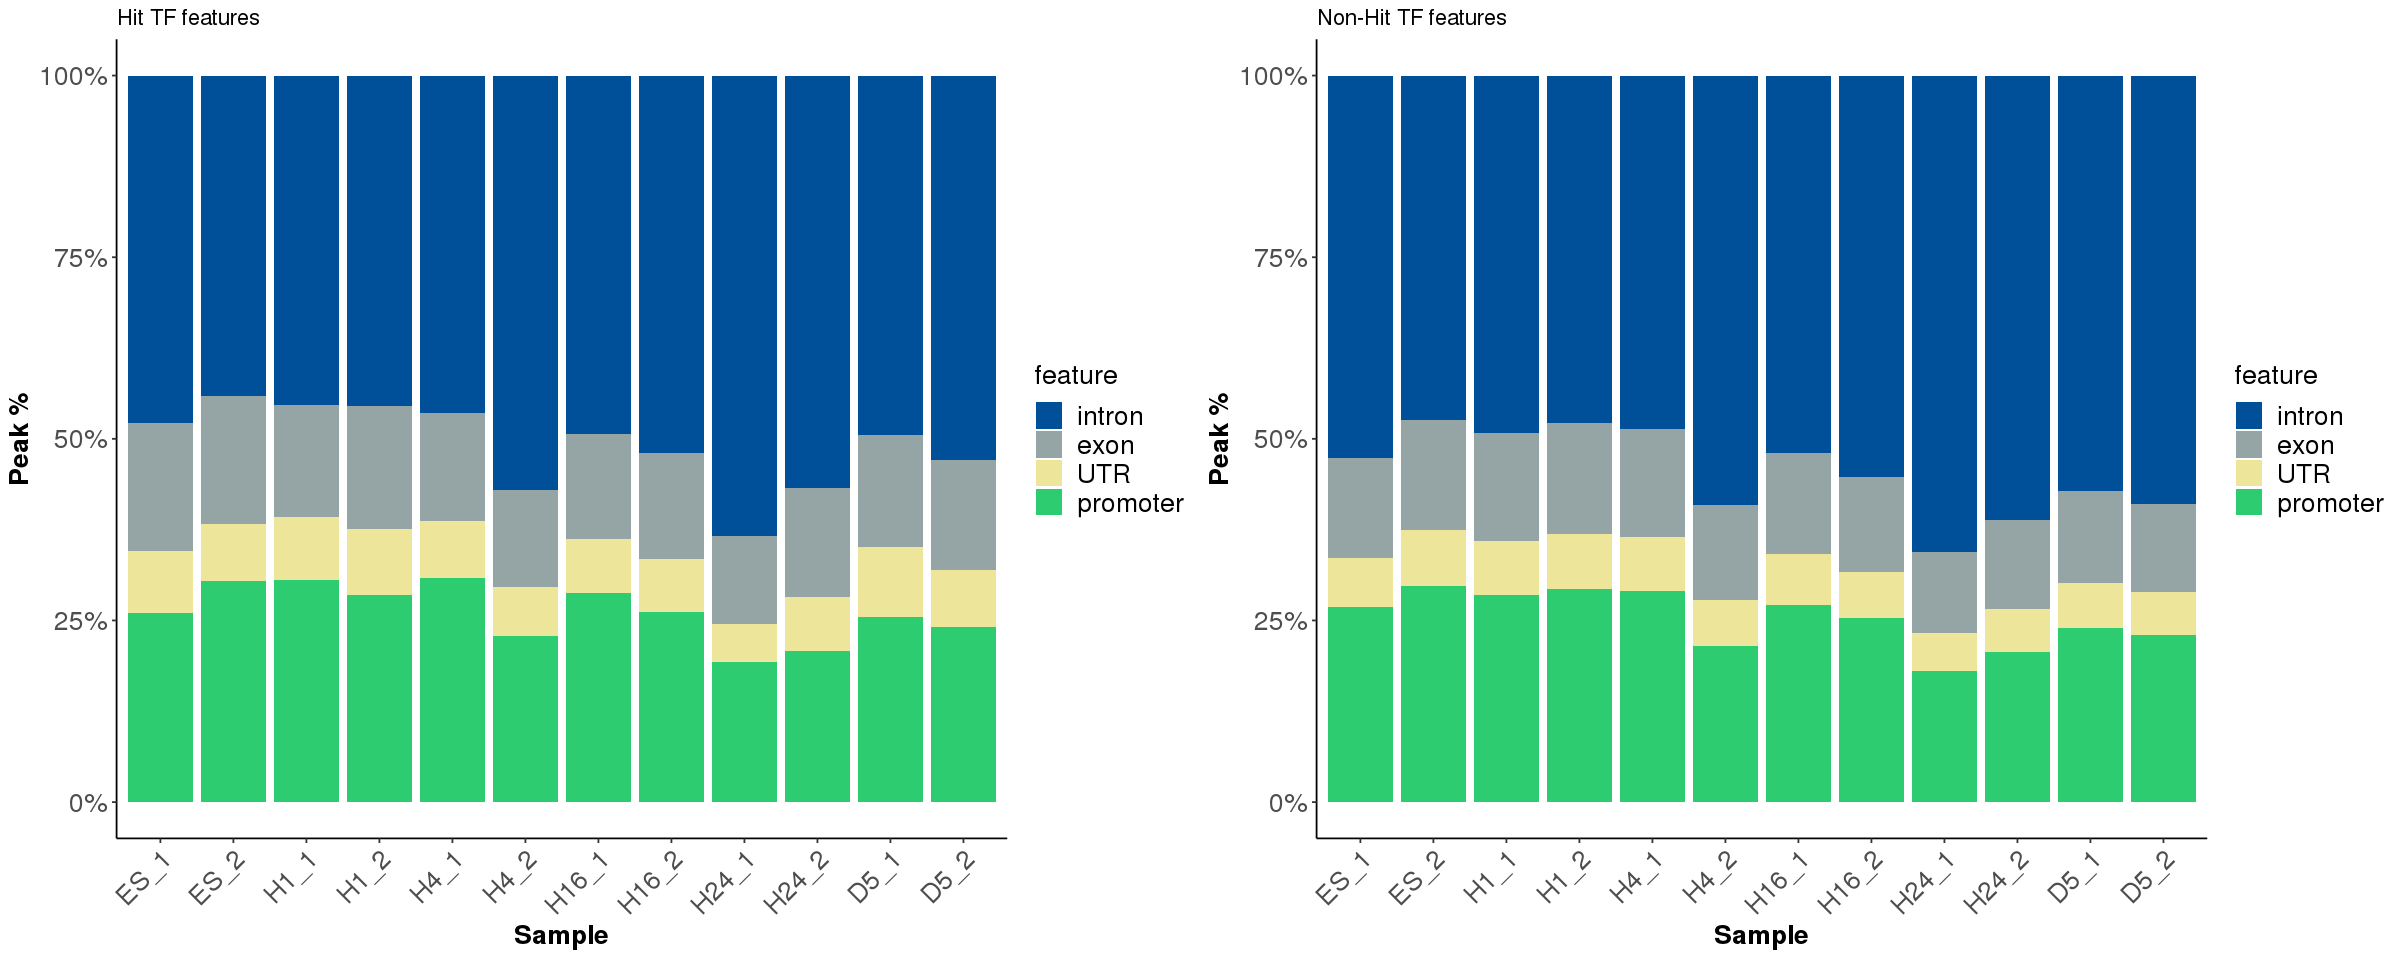

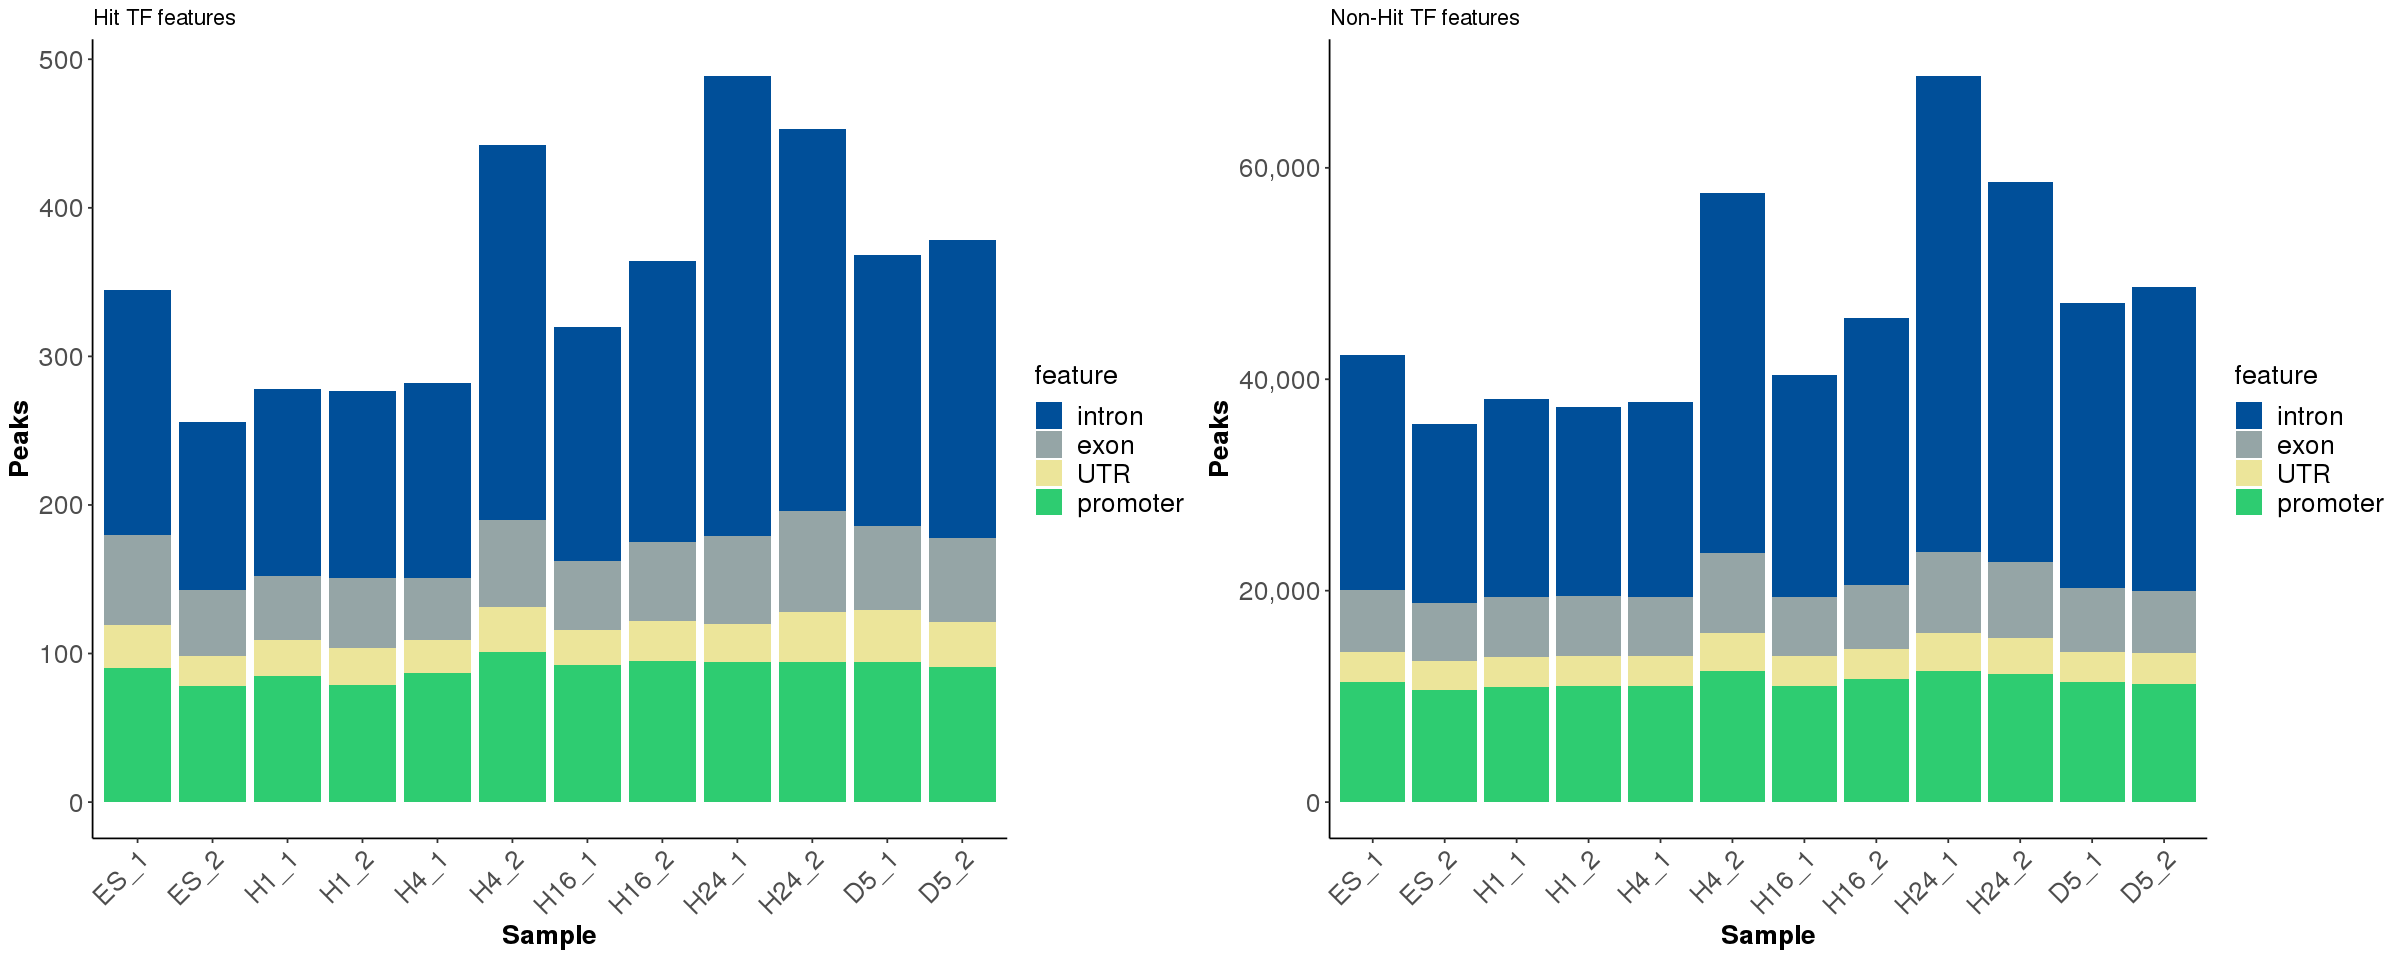

In [60]:
gridExtra::grid.arrange(gg.hits, gg.nonhits, nrow = 1)
gridExtra::grid.arrange(gg.hits.2, gg.nonhits.2, nrow = 1)

In [437]:
write.table(peak.sum.hits, file = file.path(figure_dir, "peak_summary_hitTFs.csv"), quote=F, sep = ",", row.names=F, col.names=T)
write.table(peak.sum.nonhits, file = file.path(figure_dir, "peak_summary_nonHitTFs.csv"), quote=F, sep = ",", row.names=F, col.names=T)

### Zoom in on specific gene

In [363]:
focused_genes <- c("NEUROG2", "NEUROG1", "ZBTB18", "PRDM6", "ARID1B", "INSM1", "PHOX2A", "HOXB3", "VAX2")
combined_df <- map_df(peak.ls, rbind)

In [364]:
barplot_genes <- map(focused_genes, ~ filter(combined_df, gene == .x)) %>% map(., ~ group_by(.x, sample, feature)) %>% 
                map(., ~ summarise(.x, n_distinct(name))) %>%
                map(., ~ mutate_at(.x, .vars = "feature", .funs = ~ factor(.x, levels = feature_levels))) %>%
                map(., ~rename(.x, `n_distinct(name)` = "peaknum"))

In [365]:
names(barplot_genes) <- focused_genes

In [366]:
gene_plot.ls <- barplot_genes %>% 
                map2(., focused_genes, ~ ggplot(.x) + 
                                       geom_bar(aes(x = sample, y = peaknum, fill = feature), 
                                                stat = "identity", position = "fill") + 
                                        scale_fill_manual(values=c("intergenic" = "darkseagreen4", 
                                                                   "intron"= "tan", 
                                                                   "exon" = "steelblue", 
                                                                   "UTR" = "seagreen", 
                                                                   "promoter" = "salmon3")) + 
                                        labs(title = paste0(.y)) +
                                        xlab("Sample") + ylab("Peaks") +
                                        scale_y_continuous(labels = scales::percent) )

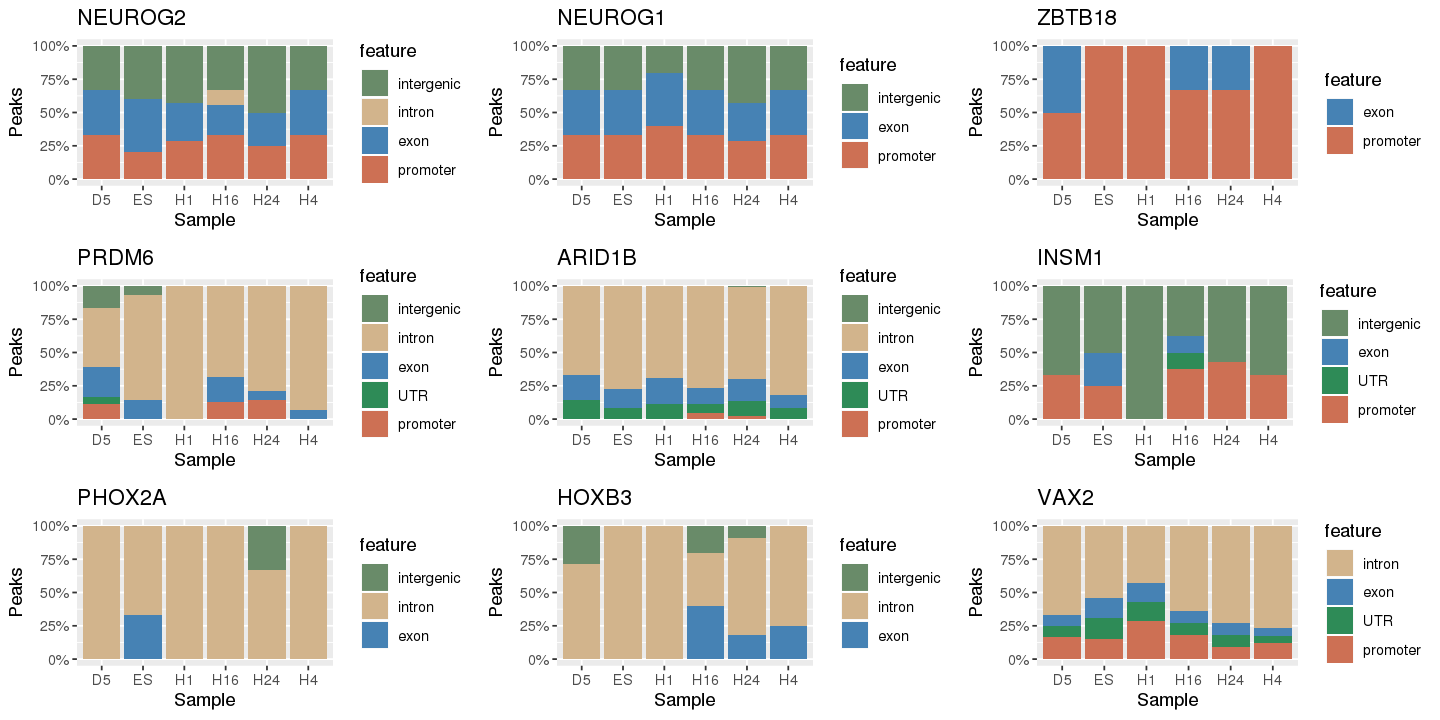

In [367]:
grid.arrange(grobs = gene_plot.ls, nrow = 3)

In [372]:
gene_plot.ls2 <- barplot_genes %>% 
                map2(., focused_genes, ~ ggplot(.x) + 
                                       geom_bar(aes(x = sample, y = peaknum, fill = feature), 
                                                stat = "identity") + 
                                        scale_fill_manual(values=c("intergenic" = "darkseagreen4", 
                                                                   "intron"= "tan", 
                                                                   "exon" = "steelblue", 
                                                                   "UTR" = "seagreen", 
                                                                   "promoter" = "salmon3")) + 
                                        labs(title = paste0(.y)) +
                                        xlab("Sample") + ylab("Peaks") + 
                                        scale_y_continuous(labels = scales::comma) )

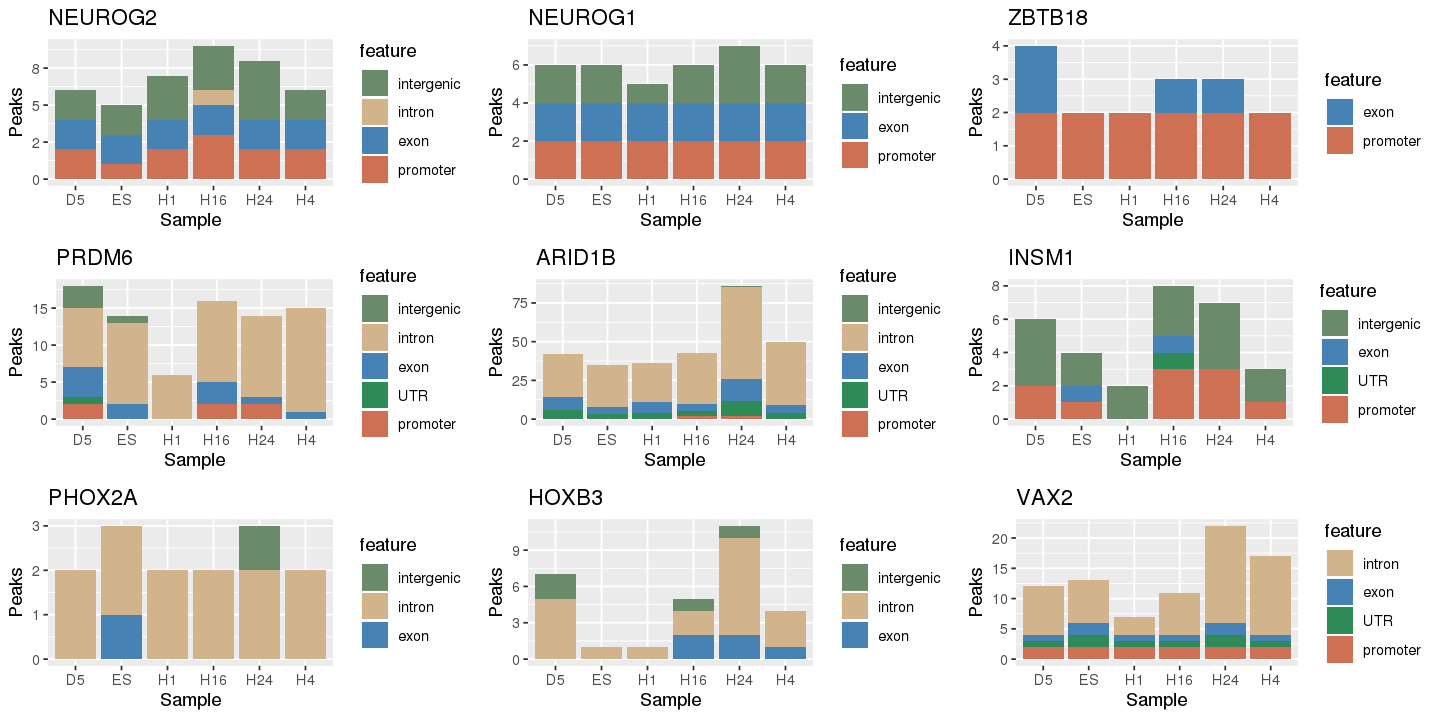

In [373]:
grid.arrange(grobs = gene_plot.ls2, nrow = 3)

In [375]:
library(WriteXLS)

In [376]:
WriteXLS(barplot_genes, ExcelFileName = file.path(figure_dir, "peak_summary_selectedGenes.xlsx"), SheetNames=names(barplot_genes), row.names=F, col.names=T)

## Meta Analysis

### Plot meta_gene per TF

In [62]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/meta_analysis")

In [63]:
samples.files <- list.files(".", "AllTF.*coverage") %>% naturalsort

In [64]:
samples <- map_chr(samples.files, ~str_remove(.x, ".AllTF.promoter.10bpwindow.coverage"))
samples.lev <- factor(samples, levels = samples)

In [65]:
sample_lookup <- tribble(~ sample, ~ time, ~ rep, 
                        "ATAC1", "ES", "1",
                        "ATAC2", "ES", "2",
                        "ATAC3", "H1", "1",
                        "ATAC4", "H1", "2",
                        "ATAC5", "H4", "1",
                        "ATAC6", "H4", "2",
                        "ATAC7", "H16", "1",
                        "ATAC8", "H16", "2",
                        "ATAC9", "D1", "1",
                        "ATAC10", "D1", "2",
                        "ATAC11", "D4", "1",
                        "ATAC12", "D4", "2",)

In [66]:
sample_lookup %>% t
samples %>% t

sample,ATAC1,ATAC2,ATAC3,ATAC4,ATAC5,ATAC6,ATAC7,ATAC8,ATAC9,ATAC10,ATAC11,ATAC12
time,ES,ES,H1,H1,H4,H4,H16,H16,D1,D1,D4,D4
rep,1,2,1,2,1,2,1,2,1,2,1,2


ATAC1,ATAC2,ATAC3,ATAC4,ATAC5,ATAC6,ATAC7,ATAC8,ATAC9,ATAC10,ATAC11,ATAC12


In [67]:
sample_lookup <- mutate_at(sample_lookup, "sample", ~ factor(.x, levels = samples.lev)) %>%
                    mutate_at("time", ~ factor(.x, levels = c("ES", "H1","H4","H16","D1","D4")))

In [68]:
# Read in all the sample reads and add relevant columns
AllTF_coverages <- map2_df(samples.files, samples, 
                  ~ read.table(.x, sep = "\t", header = F,
                               col.names = c("chr", "start","end","gene","window","cov"),
                               stringsAsFactors = F) %>% 
                         add_column("sample"=.y)) %>% mutate_at("sample", ~factor(.x, levels = samples.lev))
AllTF_coverages <- left_join(AllTF_coverages, sample_lookup, by = "sample")
AllTF_coverages <- mutate(AllTF_coverages, "isHit"=if_else(gene %in% hitlist, T, F))

In [69]:
AllTF_coverages %>% head
AllTF_coverages %>% dim

,chr,start,end,gene,window,cov,sample,time,rep,isHit
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<fct>,<fct>,<chr>,<lgl>
1,chr1,2226319,2226329,SKI,1,0.3428990,ATAC1,ES,1,TRUE
2,chr1,2226329,2226339,SKI,2,0.3428990,ATAC1,ES,1,TRUE
3,chr1,2226339,2226349,SKI,3,0.4163775,ATAC1,ES,1,TRUE
4,chr1,2226349,2226359,SKI,4,0.4653630,ATAC1,ES,1,TRUE
5,chr1,2226359,2226369,SKI,5,0.3673920,ATAC1,ES,1,TRUE
6,chr1,2226369,2226379,SKI,6,0.2939140,ATAC1,ES,1,TRUE


[1] 9067200      10

In [70]:
# plot function
plot1 <- function(choose.gene, coverage) {
    if (choose.gene %in% unique(coverage$gene)) {
        tss <- filter(coverage, gene == choose.gene) %>% pull(end) %>% max %>% `-`(1999)
        gg <- coverage %>% filter(gene == choose.gene) %>% 
            ggplot() + geom_line(aes(x = tss - start, y = cov, color = time)) +
                geom_vline(xintercept = 0, color = "red", alpha = .5, linetype="dashed") +
                coord_cartesian(xlim = c(-2000,2000)) +
                theme_classic() +
                theme() +
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                legend.text=element_text(size=16),legend.title=element_text(size=16))+
                labs(title = paste0(choose.gene)) + 
                xlab(label = "Distance from TSS") +
                ylab(label = "Coverage")
        return(gg+ facet_wrap(. ~ rep, labeller = as_labeller(c("1"="rep1","2"="rep2"))))
    } else {
        print(paste0(choose.gene, "not found in data!"))
    }
    
}

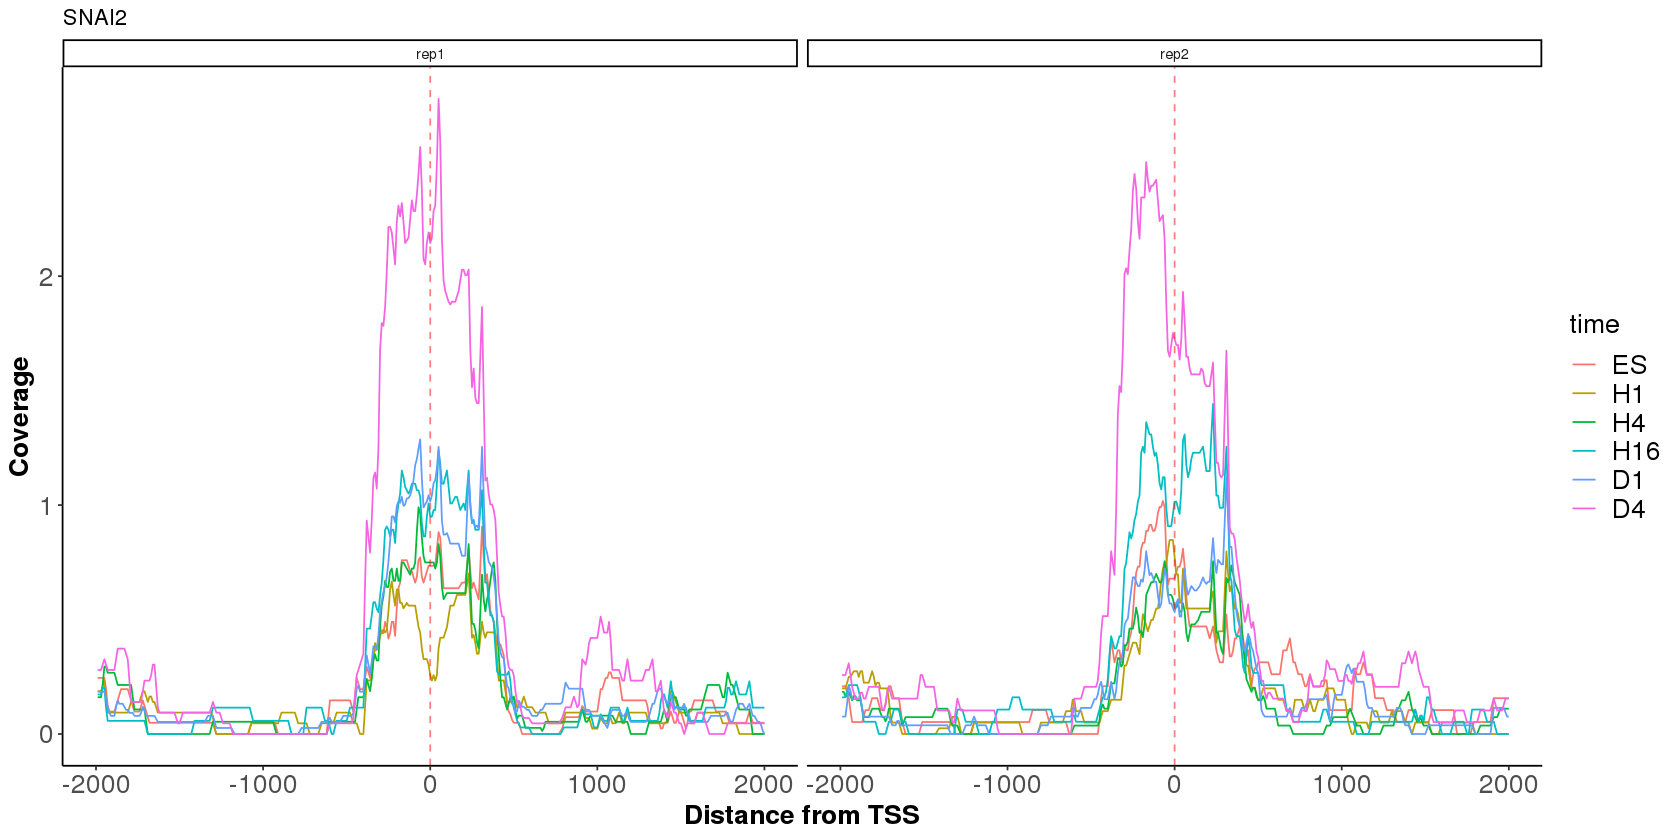

In [675]:
# e.g. 
plot1("SNAI2", AllTF_coverages)

In [72]:
# this gene is not in coverage data
setdiff(hitlist, Hit_coverages$gene)

ERROR: Error in setdiff(hitlist, Hit_coverages$gene): object 'Hit_coverages' not found


#### Plot many genes at once

In [303]:
gene.ls <- Hit_coverages$gene %>% unique

#### Summarize by gene, the read counts

In [384]:
AllTF_promoter_sums <- select(AllTF_coverages, chr, start, end, gene, cov, sample, time, rep, isHit) %>%
                            group_by(chr, gene, sample, time, rep, isHit) %>%
                            summarise_at("cov", "sum")

In [440]:
AllTF_promoter_sums <- AllTF_promoter_sums %>% 
                            ungroup %>% 
                            select(-sample) %>% 
                            spread(rep, cov, ) %>% 
                            rename("1"="rep1","2"="rep2") %>%
                            mutate("avgCov"=(rep1 + rep2)/2)

In [445]:
library(pheatmap)

In [472]:
anno_rows <- select(AllTF_promoter_sums, gene, isHit) %>% 
                distinct %>%
                column_to_rownames("gene")

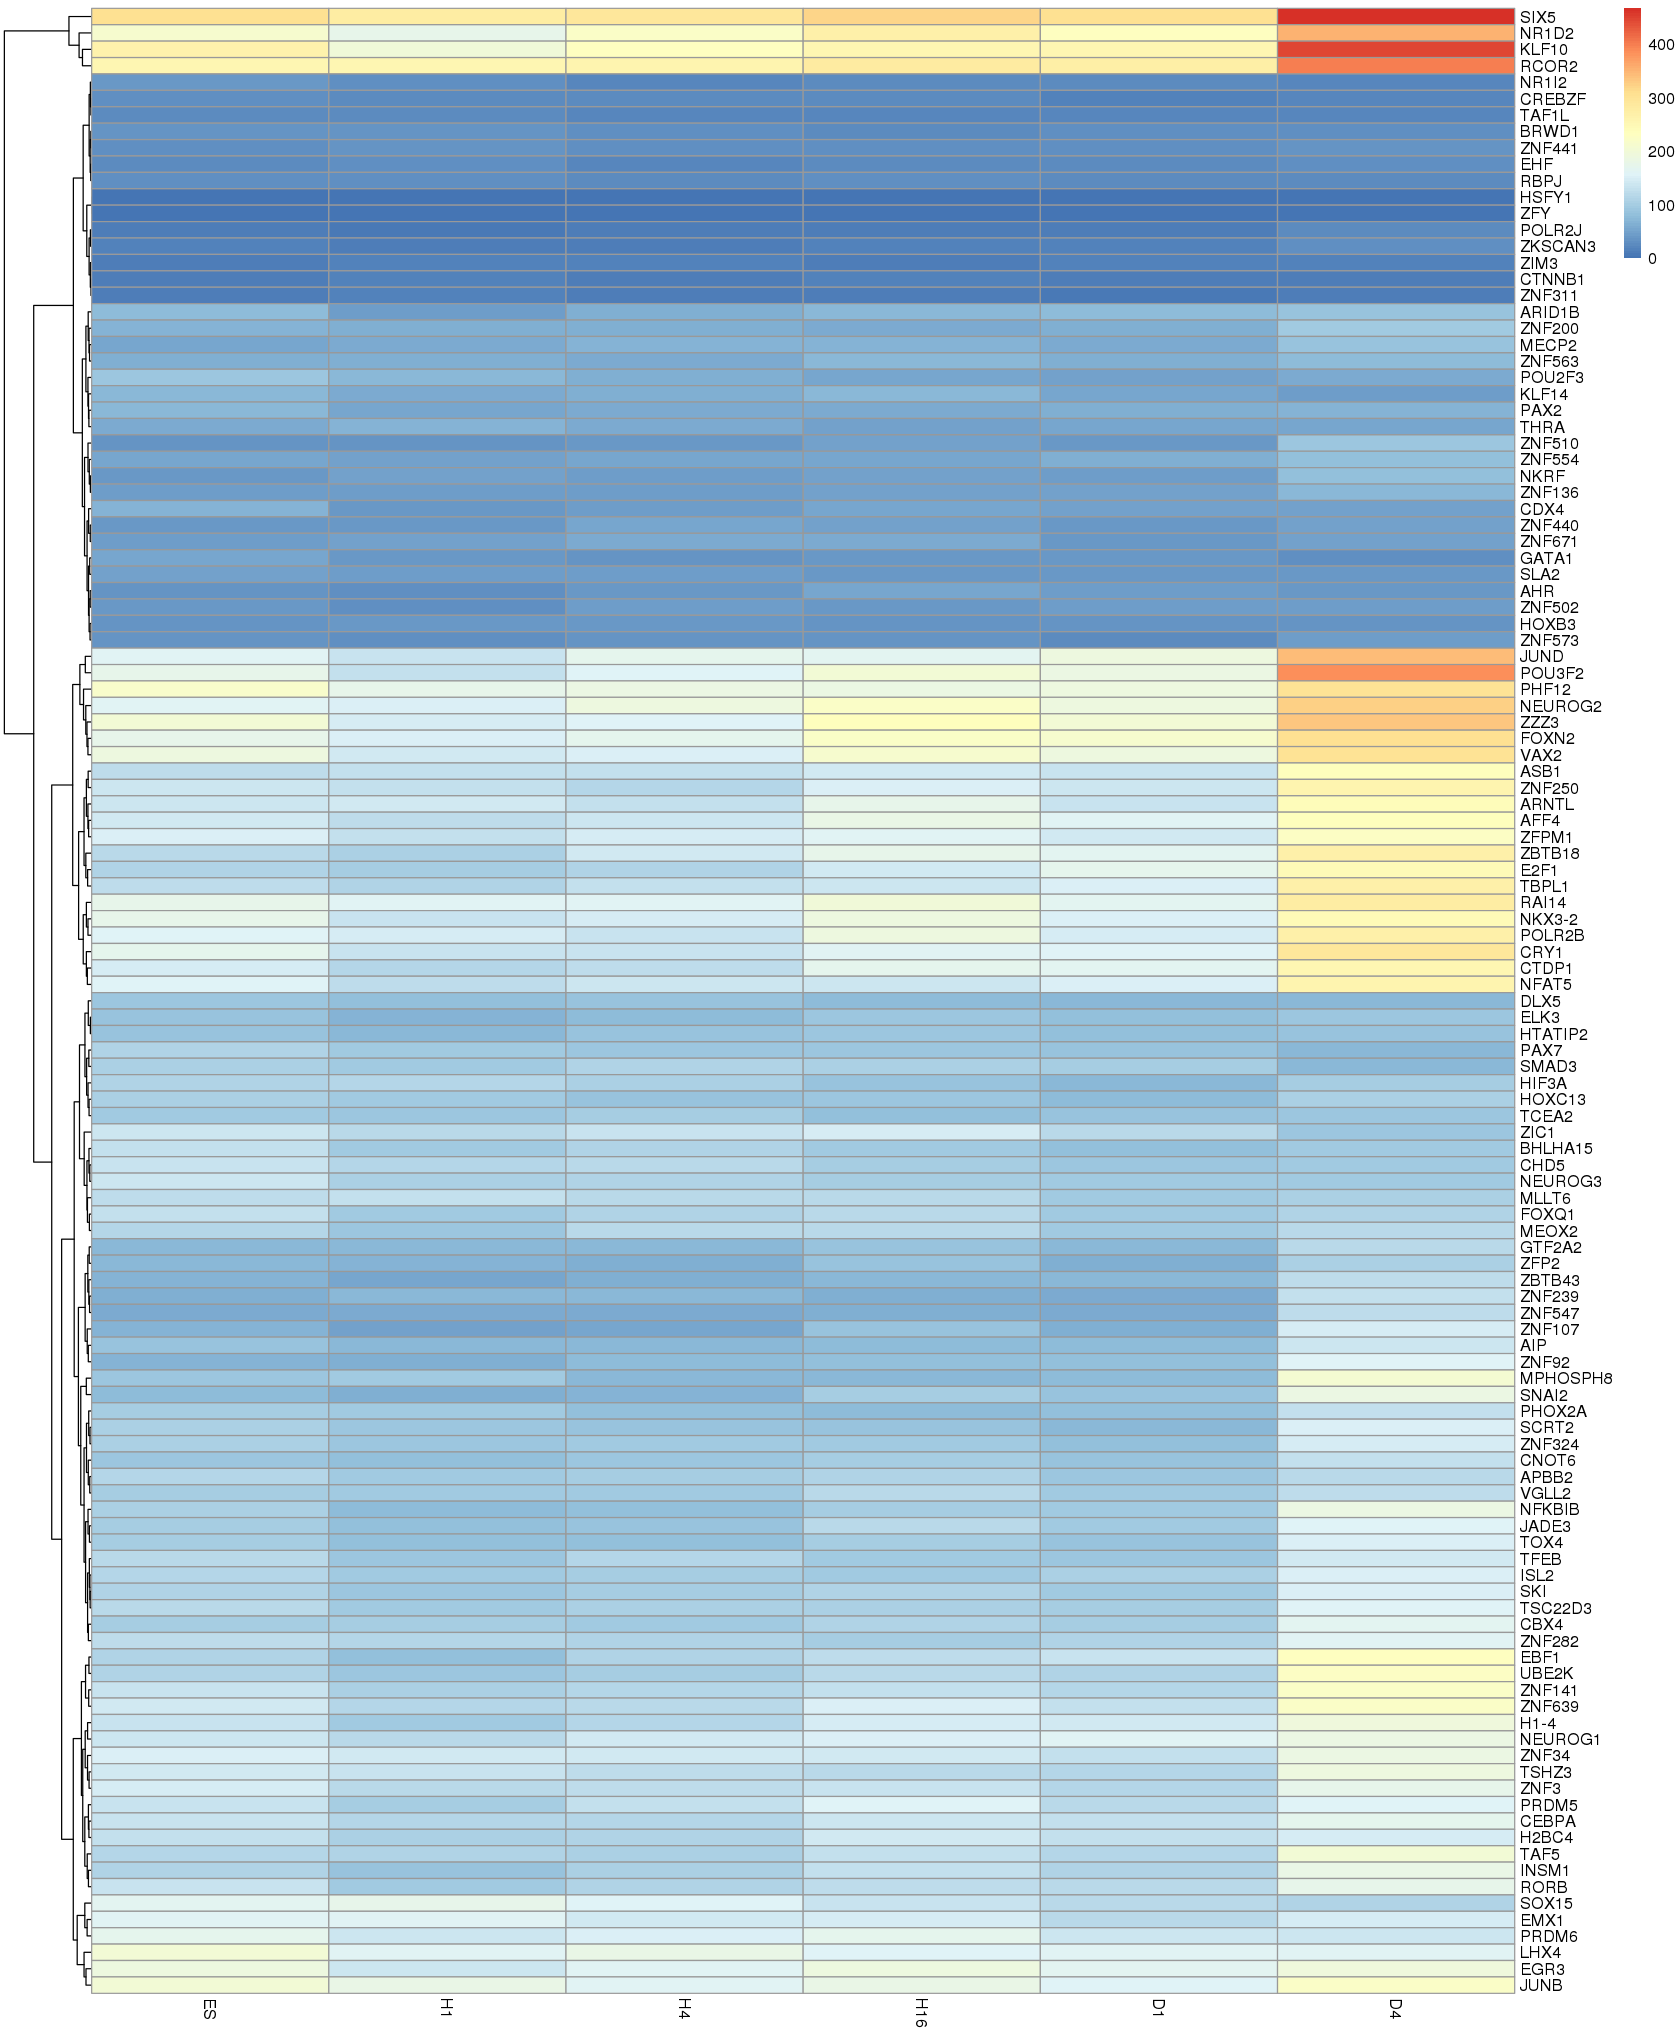

In [479]:
AllTF_promoter_sums %>% 
        select(gene, isHit, time, avgCov) %>%
        spread(time, avgCov) %>%
        filter(isHit) %>%
        select(-isHit) %>% 
        column_to_rownames("gene") %>% as.matrix %>%
        pheatmap(mat = ., cluster_rows = T, cluster_cols = F)

## Promoter region ATAC read count analysis - violin plots

count files: `/c/groups/sanjana_lab/cdai/TFscreen/atac/bams_v3/calc_TF_promoters_counts.sh/ATAC*.PE.mapq.bam.counts`

In [73]:
setwd("/c/groups/sanjana_lab/cdai/TFscreen/atac/bams_v3")

In [74]:
promoter.count.files <- list.files('.', "PE.mapq.bam.counts") %>% naturalsort

sample <- map_chr(promoter.count.files, ~ str_remove(.x, ".PE.mapq.bam.counts"))

sample <- factor(sample, levels = sample)

promoter.counts <- map2_df(promoter.count.files, sample,
                           ~ read.table(.x, header = F, sep = "\t", stringsAsFactors = F,
                                        col.names = c("chr","start", "end", "gene", "score", "strand", "counts")) %>%
                             add_column("sample"=.y))

In [75]:
atac_library_totals <- read.table("PE.mapq.bam.library.tally", header = F, sep = " ", stringsAsFactors = F)[1:12,]
atac_library_totals <- data.frame("sample" = map_chr(atac_library_totals$V1, ~ str_remove(.x, ".PE.mapq.bam")), 
                                        "totalreads" = atac_library_totals$V5)

In [76]:
promoter.counts <- left_join(promoter.counts, atac_library_totals, by = "sample")

Warning message:
“Column `sample` joining factors with different levels, coercing to character vector”


In [77]:
promoter.counts <- mutate(promoter.counts, "CPM" = counts * 1e6/totalreads )

In [78]:
promoter.counts[c(1,50,3000,5000),]

,chr,start,end,gene,score,strand,counts,sample,totalreads,CPM
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<dbl>
1,chr1,998173,1002172,HES4,1,-,442,ATAC1,23580787,18.74407
50,chr1,39900257,39904256,MYCL,1,-,377,ATAC1,23580787,15.98759
3000,chr13,44575148,44579147,TSC22D1,1,-,520,ATAC2,21330270,24.37850
5000,chr16,2266398,2270397,RNPS1,1,-,316,ATAC3,23895858,13.22405


In [79]:
promoter.counts <- mutate(promoter.counts, "isTF"=if_else(gene %in% tflist, T, F)) %>% 
        mutate("isHit"=if_else(gene %in% hitlist, T,F))

In [80]:
sample_lookup <- tribble(~ sample, ~ time, ~ rep, 
                        "ATAC1", "ES", "1",
                        "ATAC2", "ES", "2",
                        "ATAC3", "H1", "1",
                        "ATAC4", "H1", "2",
                        "ATAC5", "H4", "1",
                        "ATAC6", "H4", "2",
                        "ATAC7", "H16", "1",
                        "ATAC8", "H16", "2",
                        "ATAC9", "D1", "1",
                        "ATAC10", "D1", "2",
                        "ATAC11", "D4", "1",
                        "ATAC12", "D4", "2",)

In [81]:
sample_lookup <- mutate_at(sample_lookup, "sample", ~ factor(.x, levels = sample)) %>%
                    mutate_at("time", ~ factor(.x, levels = c("ES", "H1","H4","H16","D1","D4")))

In [82]:
promoter.counts <- left_join(promoter.counts, sample_lookup, by = "sample")

Warning message:
“Column `sample` joining character vector and factor, coercing into character vector”


In [83]:
head(promoter.counts)

,chr,start,end,gene,score,strand,counts,sample,totalreads,CPM,isTF,isHit,time,rep
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<dbl>,<lgl>,<lgl>,<fct>,<chr>
1,chr1,998173,1002172,HES4,1,-,442,ATAC1,23580787,18.744073,TRUE,FALSE,ES,1
2,chr1,2226319,2230318,SKI,1,+,344,ATAC1,23580787,14.588148,TRUE,TRUE,ES,1
3,chr1,3067168,3071167,PRDM16,1,+,222,ATAC1,23580787,9.414444,TRUE,FALSE,ES,1
4,chr1,3650516,3654515,TP73,1,+,316,ATAC1,23580787,13.400740,TRUE,FALSE,ES,1
5,chr1,6178322,6182321,CHD5,1,-,315,ATAC1,23580787,13.358333,TRUE,TRUE,ES,1
6,chr1,6422671,6426670,HES2,1,-,337,ATAC1,23580787,14.291296,TRUE,FALSE,ES,1


In [84]:
promter.counts2 <- promoter.counts %>% select(gene, CPM, isTF, isHit, time) %>% 
        group_by(gene, isTF, isHit, time) %>%
        summarise_all(sum)

In [85]:
head(promter.counts2)

gene,isTF,isHit,time,CPM
<chr>,<lgl>,<lgl>,<fct>,<dbl>
ABL1,TRUE,FALSE,ES,32.57905
ABL1,TRUE,FALSE,H1,30.60615
ABL1,TRUE,FALSE,H4,35.99634
ABL1,TRUE,FALSE,H16,40.33014
ABL1,TRUE,FALSE,D1,41.91591
ABL1,TRUE,FALSE,D4,51.67339


Warning message:
“Removed 62 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 62 rows containing non-finite values (stat_boxplot).”


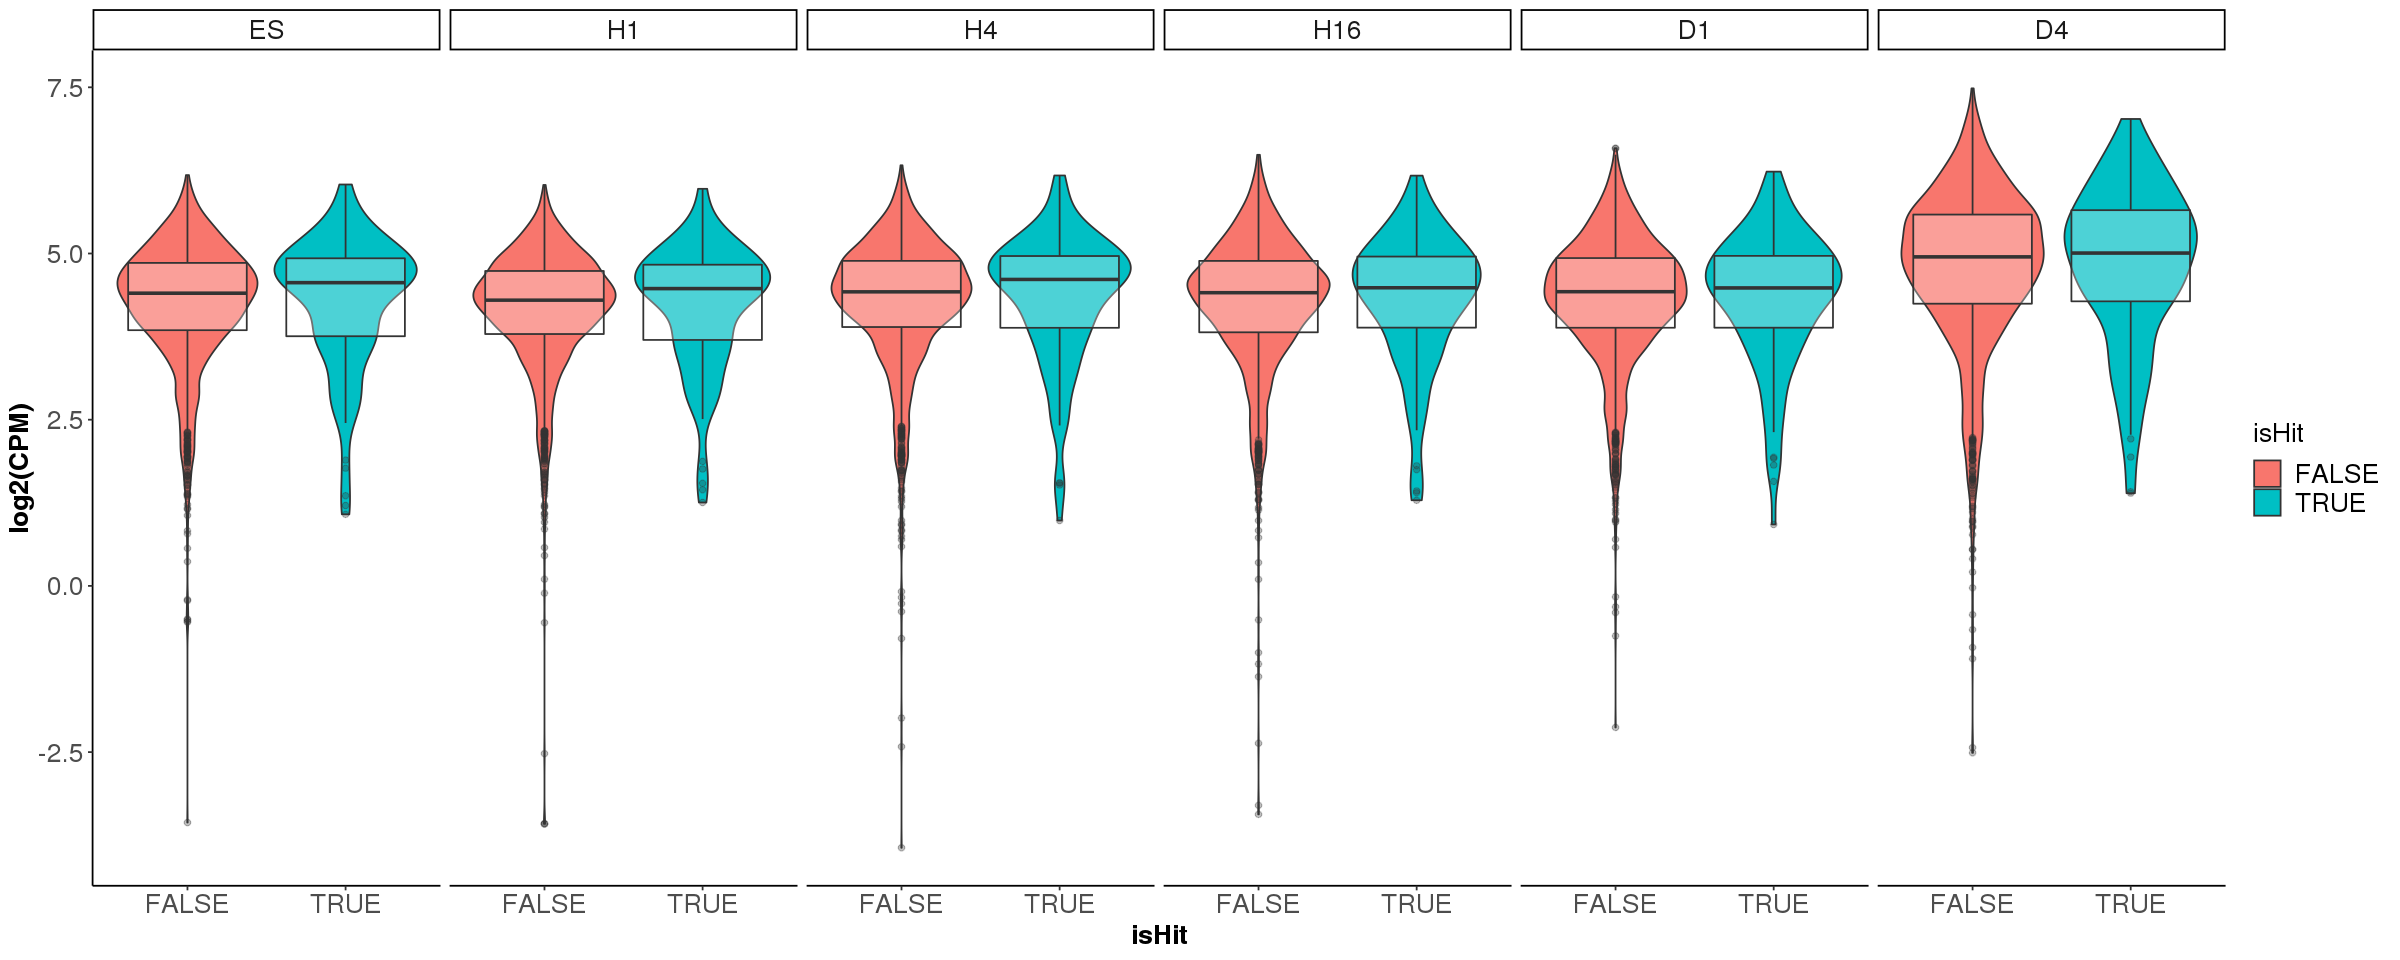

In [88]:
promter.counts2  %>%
    ggplot() + geom_violin(aes(x=isHit, y=log2(CPM), fill = isHit)) + 
                geom_boxplot(aes(x=isHit, y=log2(CPM)), alpha = .3) +
                theme_classic() + 
                theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
                      legend.text=element_text(size=16),legend.title=element_text(size=16), strip.text.x = element_text(size = 16)) +
                facet_wrap(~ time, ncol = 6)

---

In [89]:
rna.counts <- read.table("../../RNAseq_raw_readcount_properGenename.txt", header = T, stringsAsFactors = F) %>%
                column_to_rownames("gene_name")

keep <- which(apply(rna.counts, 1, sum) > 10)

# calc CPM
rna.counts <- apply(rna.counts[keep,], 2, function(x) x * 1e6/sum(x))

rna.sample.names <- read.csv('../../RNASeqSampleNames.csv', stringsAsFactors=F)

In [90]:
rna.sample.names %>% t
head(rna.counts)

sample,S01_B1,S01_B2,S02_B1,S02_B2,S03_B1,S03_B2,S04_B1,S04_B2,S05_B1,S05_B2,⋯,S18_B1,S18_B2,S19_B1,S19_B2,S20_B1,S20_B2,S21_B1,S21_B2,S22_B1,S22_B2
condition,WT.ES,WT.ES,WT.ES,WT.ES,K108.ES,K108.ES,K108.ES,K108.ES,K112.ES,K112.ES,⋯,WT.D1,WT.D1,WT.D2,WT.D2,WT.D2,WT.D2,WT.D7,WT.D7,WT.D7,WT.D7
group,ES,ES,ES,ES,KO.ES,KO.ES,KO.ES,KO.ES,KO.ES,KO.ES,⋯,D1,D1,D2,D2,D2,D2,D7,D7,D7,D7


,S01_B1,S01_B2,S02_B1,S02_B2,S07_B1,S07_B2,S08_B1,S08_B2,S13_B1,S13_B2,⋯,S18_B1,S18_B2,S19_B1,S19_B2,S20_B1,S20_B2,S21_B1,S21_B2,S22_B1,S22_B2
A1BG,44.4949591,12.1105519,22.810295,22.821469,30.6245568,7.081035,33.6459043,13.0346487,2.872066,2.9988634,⋯,6.38779,4.3277546,18.014485,8.2116690,0.5276596,10.8499042,23.2528838,12.6804021,14.3968062,23.3581764
A1BG-AS1,2.4917177,2.0468538,1.228247,0.000000,9.7697973,5.057882,11.9251306,2.3325161,3.476711,0.8746685,⋯,0.00000,1.9093035,6.646121,3.3162510,0.0000000,3.3672116,0.5407647,0.0000000,5.0388822,3.7674478
A1CF,0.5339395,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.1419658,0.2744137,0.000000,0.0000000,⋯,0.00000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.6027916
A2M,0.0000000,0.0000000,0.000000,0.000000,5.6364215,7.586824,8.9438480,8.3696165,0.000000,0.4998106,⋯,53.89698,26.9848228,35.154481,49.5858476,31.8354603,46.0185591,0.2703824,9.9780213,0.7198403,4.5209374
A2M-AS1,0.0000000,0.0000000,0.000000,0.000000,0.9394036,0.000000,1.2776926,0.5488273,0.000000,2.4990529,⋯,0.00000,0.2545738,0.000000,0.0000000,0.0000000,1.1224039,0.0000000,1.0393772,0.0000000,0.9041875
A2ML1,3.9155564,0.1705712,2.807421,2.212991,1.5030457,0.000000,0.0000000,0.6860341,2.872066,0.2499053,⋯,0.00000,0.1272869,0.000000,0.4737501,2.4624113,0.7482693,0.5407647,0.4157509,0.2399468,2.2604687


In [91]:
# combine interested time points
rna.ES <- as.data.frame(rna.counts) %>% select(S13_B1:S14_B2) %>% apply(1, sum)
rna.H16 <- as.data.frame(rna.counts) %>% select(S15_B1:S16_B2) %>% apply(1, sum)
rna.D1 <- as.data.frame(rna.counts) %>% select(S17_B1:S18_B2) %>% apply(1, sum)
rna.D4 <- as.data.frame(rna.counts) %>% select(S21_B1:S22_B2) %>% apply(1, sum)
rna.counts2 <- cbind(rna.ES, rna.H16, rna.D1, rna.D4) %>% as.data.frame %>% rownames_to_column("gene") %>%
                    pivot_longer(rna.ES:rna.D4, names_to="time", names_prefix="rna\\.", values_to = "CPM") %>%
                    mutate("isTF"=if_else(gene %in% tflist, T, F)) %>% 
                    mutate("isHit"=if_else(gene %in% hitlist, T,F)) 

In [92]:
rna.counts2 %>% head(2)
promter.counts2 %>% head(2)

gene,time,CPM,isTF,isHit
<chr>,<chr>,<dbl>,<lgl>,<lgl>
A1BG,ES,13.361911,FALSE,FALSE
A1BG,H16,9.505803,FALSE,FALSE


gene,isTF,isHit,time,CPM
<chr>,<lgl>,<lgl>,<fct>,<dbl>
ABL1,TRUE,FALSE,ES,32.57905
ABL1,TRUE,FALSE,H1,30.60615


In [93]:
rna_atac.counts <- inner_join(rna.counts2, promter.counts2[, c("gene", "time", "CPM")], 
                              by = c("gene", "time"), suffix = c("_rna","_atac")) %>%
                    mutate_at("time", ~factor(.x, levels=c("ES","H16","D1","D4")))

Warning message:
“Column `time` joining character vector and factor, coercing into character vector”


In [94]:
rna_atac.counts %>% head

gene,time,CPM_rna,isTF,isHit,CPM_atac
<chr>,<fct>,<dbl>,<lgl>,<lgl>,<dbl>
ABL1,ES,115.6261,TRUE,FALSE,32.57905
ABL1,H16,174.7669,TRUE,FALSE,40.33014
ABL1,D1,136.4172,TRUE,FALSE,41.91591
ABL1,D4,231.3430,TRUE,FALSE,51.67339
ABT1,ES,204.8003,TRUE,FALSE,17.80647
ABT1,H16,224.4135,TRUE,FALSE,15.70469


Warning message:
“Removed 439 rows containing non-finite values (stat_smooth).”


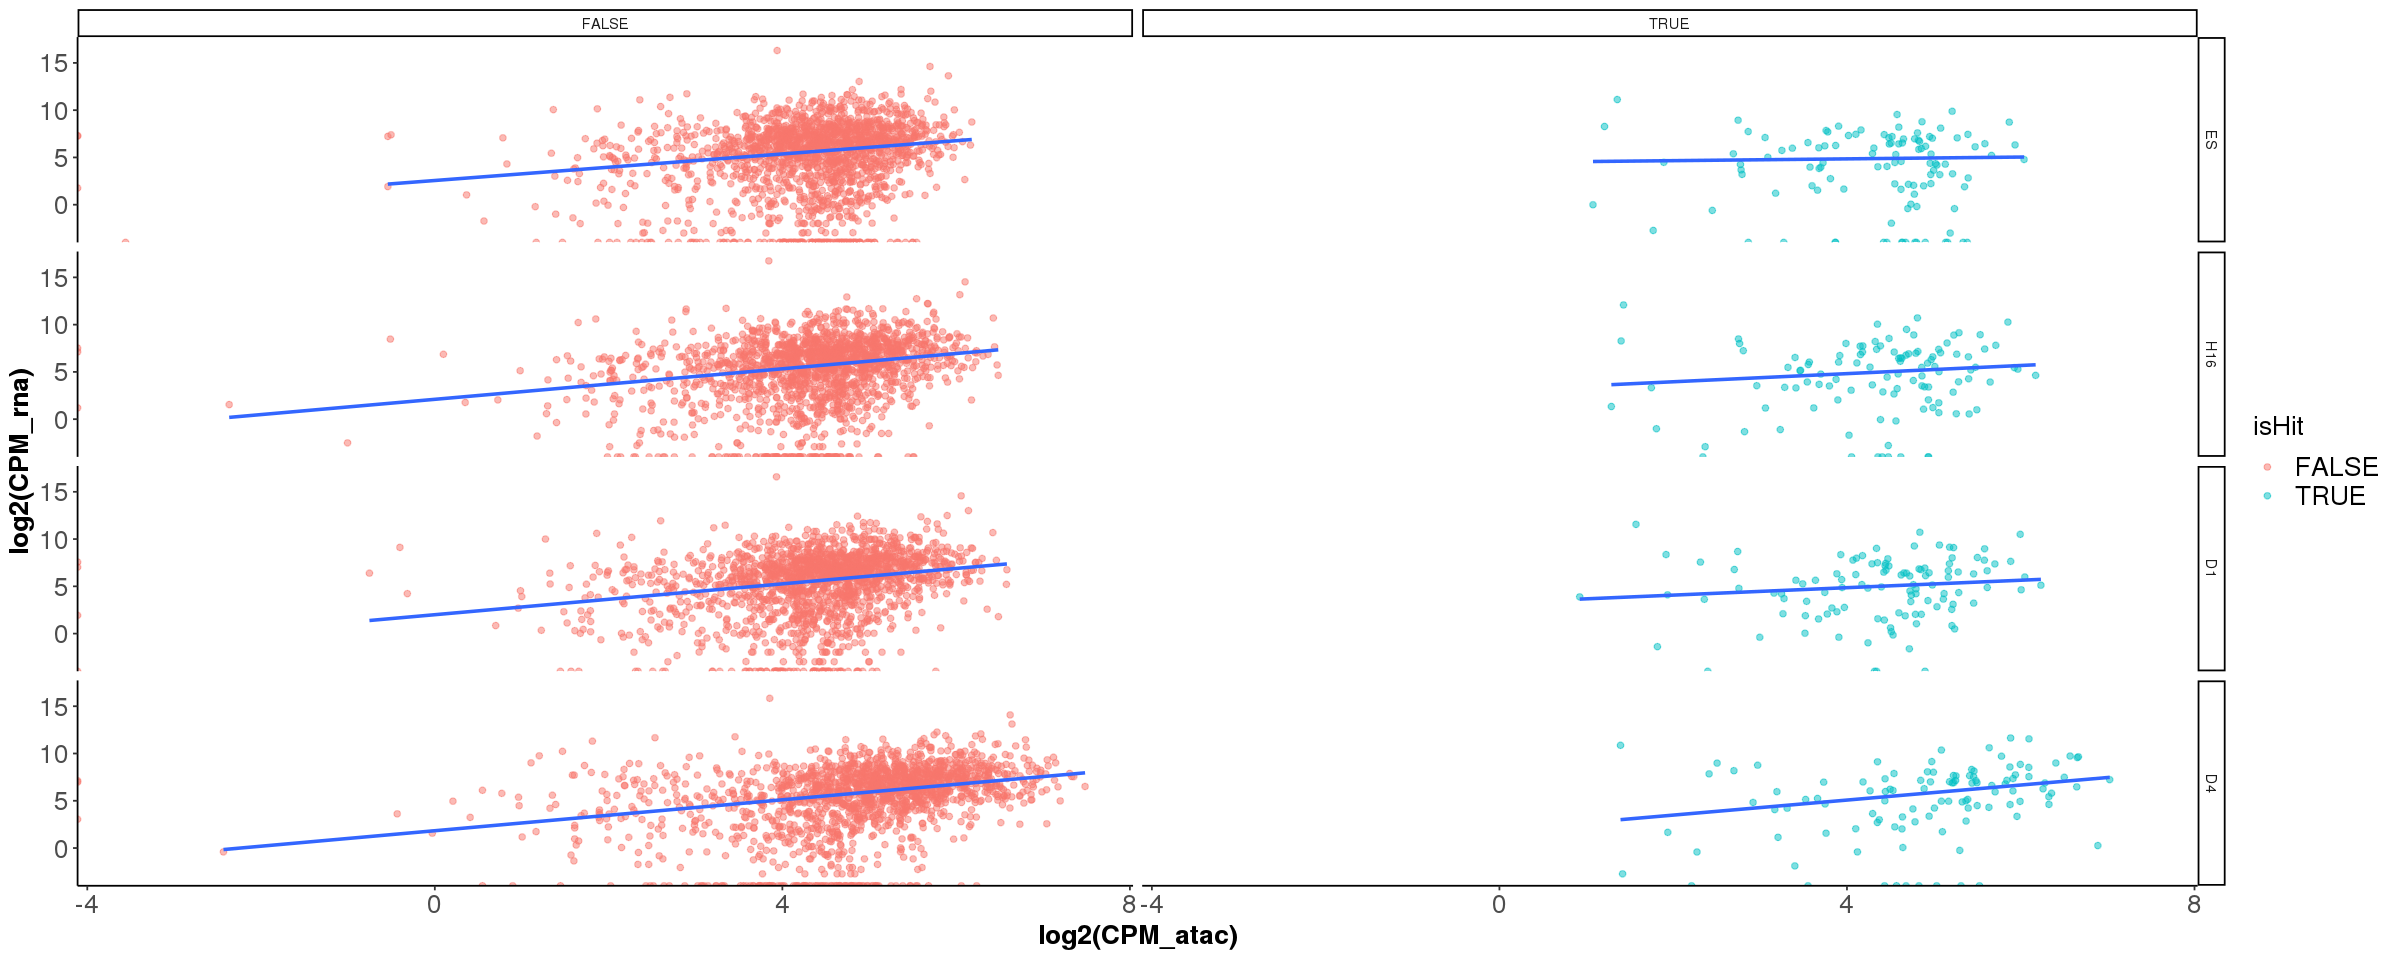

In [95]:
filter(rna_atac.counts, isTF) %>% ggplot() + 
    geom_point(aes(x=log2(CPM_atac), y=log2(CPM_rna), color=isHit), alpha = .5) +
    geom_smooth(aes(x=log2(CPM_atac), y=log2(CPM_rna)), method = "lm", se = F, size = 1, alpha=.8) +
    theme_classic() + 
    theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
    legend.text=element_text(size=16),legend.title=element_text(size=16)) +
    facet_grid(time ~ isHit) 

#### Correlation between ATAC & RNA

In [96]:
rna_atac.counts$time %>% unique

[1] ES  H16 D1  D4 
Levels: ES H16 D1 D4

In [97]:
rna_atac.corr <- pivot_wider(rna_atac.counts, names_from = c(time), values_from = c(CPM_rna, CPM_atac)) %>%
                apply(1, function(s) cor.test(x = as.numeric(c(s[4:7])), y = as.numeric(c(s[8:11])))$estimate)
rna_atac.corr.pval <- pivot_wider(rna_atac.counts, names_from = c(time), values_from = c(CPM_rna, CPM_atac)) %>%
                apply(1, function(s) cor.test(x = as.numeric(c(s[4:7])), y = as.numeric(c(s[8:11])))$p.val)

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation i

In [98]:
rna_atac.corrDF <- pivot_wider(rna_atac.counts, names_from = c(time), values_from = c(CPM_rna, CPM_atac)) %>% add_column("corr"=rna_atac.corr, "cor.p"=rna_atac.corr.pval, `.before` = "CPM_rna_ES")

In [99]:
rna_atac.corrDF %>% head

gene,isTF,isHit,corr,cor.p,CPM_rna_ES,CPM_rna_H16,CPM_rna_D1,CPM_rna_D4,CPM_atac_ES,CPM_atac_H16,CPM_atac_D1,CPM_atac_D4
<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABL1,TRUE,FALSE,0.9132862,0.086713820,115.626099,174.766887,136.417162,231.342997,32.57905,40.33014,41.91591,51.67339
ABT1,TRUE,FALSE,-0.8822787,0.117721254,204.800289,224.413458,261.673652,157.517824,17.80647,15.70469,16.17749,27.30332
ABTB1,TRUE,FALSE,-0.3027529,0.697247084,6.578397,7.404068,5.623486,6.012173,33.67076,29.35196,29.40128,40.88977
ADNP,TRUE,FALSE,0.9916090,0.008391042,459.249478,469.757908,467.953612,602.793683,31.45389,29.72952,32.72525,56.81693
ADNP2,TRUE,FALSE,-0.8785125,0.121487500,448.340702,346.594968,512.755583,201.272873,21.13896,20.39415,19.66218,32.58386
AEBP1,TRUE,FALSE,0.7979138,0.202086157,103.647879,32.116767,75.392202,4.241492,31.10841,19.54965,21.39076,20.48394


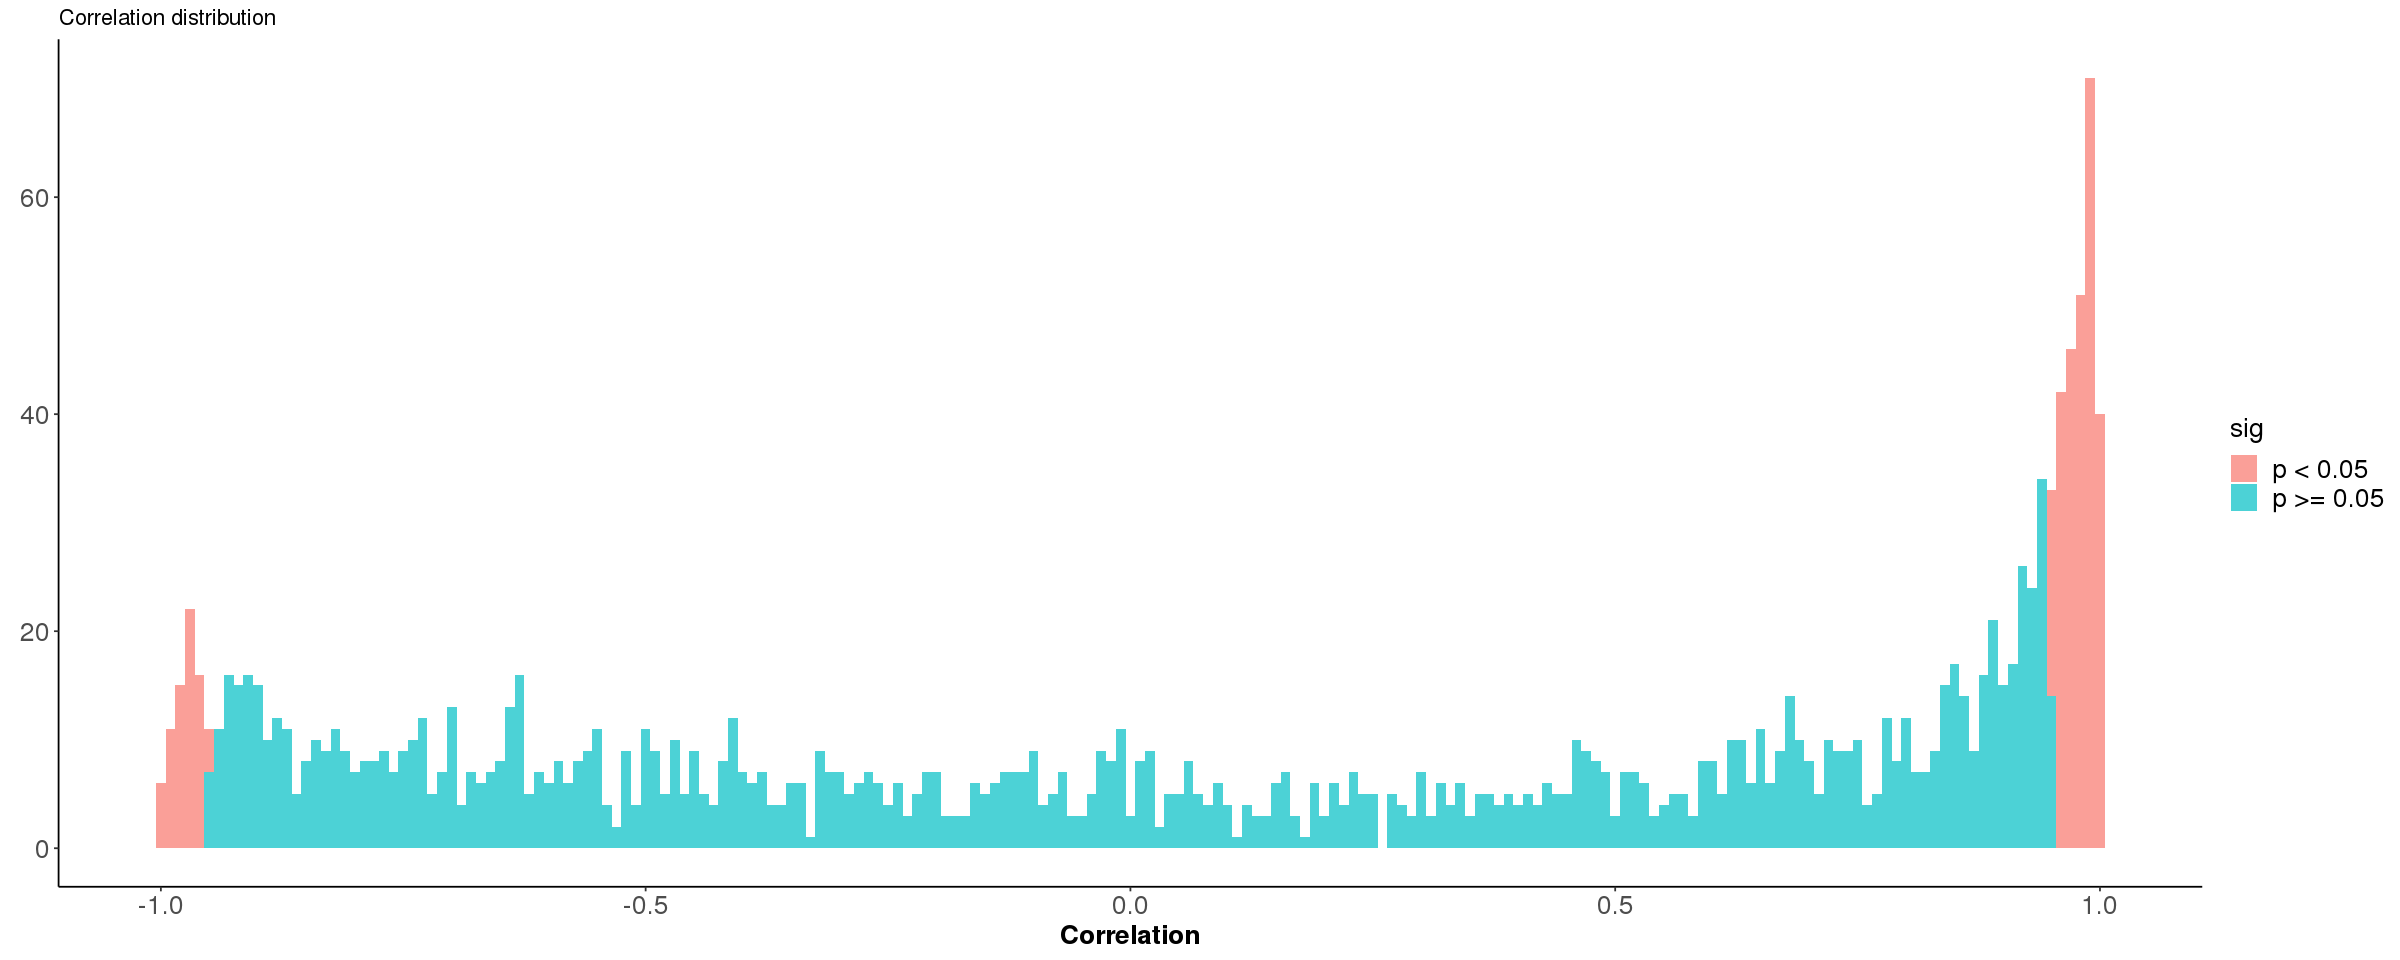

In [100]:
rna_atac.corrDF[, 1:5] %>% filter(!is.na(cor.p)) %>%
    mutate("sig"=if_else(cor.p < 5e-2, "p < 0.05", "p >= 0.05")) %>%
    ggplot + geom_histogram(aes(x=corr, fill=sig), alpha = .7, binwidth = .01) +
    theme_classic() + 
    theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"), 
    legend.text=element_text(size=16),legend.title=element_text(size=16)) +
    xlab(label = "Correlation") + ylab(label = element_blank()) +
    labs(title = "Correlation distribution")

In [101]:
cor_tf_order1 <- rna_atac.corrDF %>% select(gene:cor.p) %>%
    arrange(desc(corr)) %>% pull(gene)

In [102]:
corr.hit.tf <- rna_atac.corrDF %>% select(gene:cor.p) %>%
    filter(cor.p < 0.05 & isHit ) %>% pull(gene) %>% unique

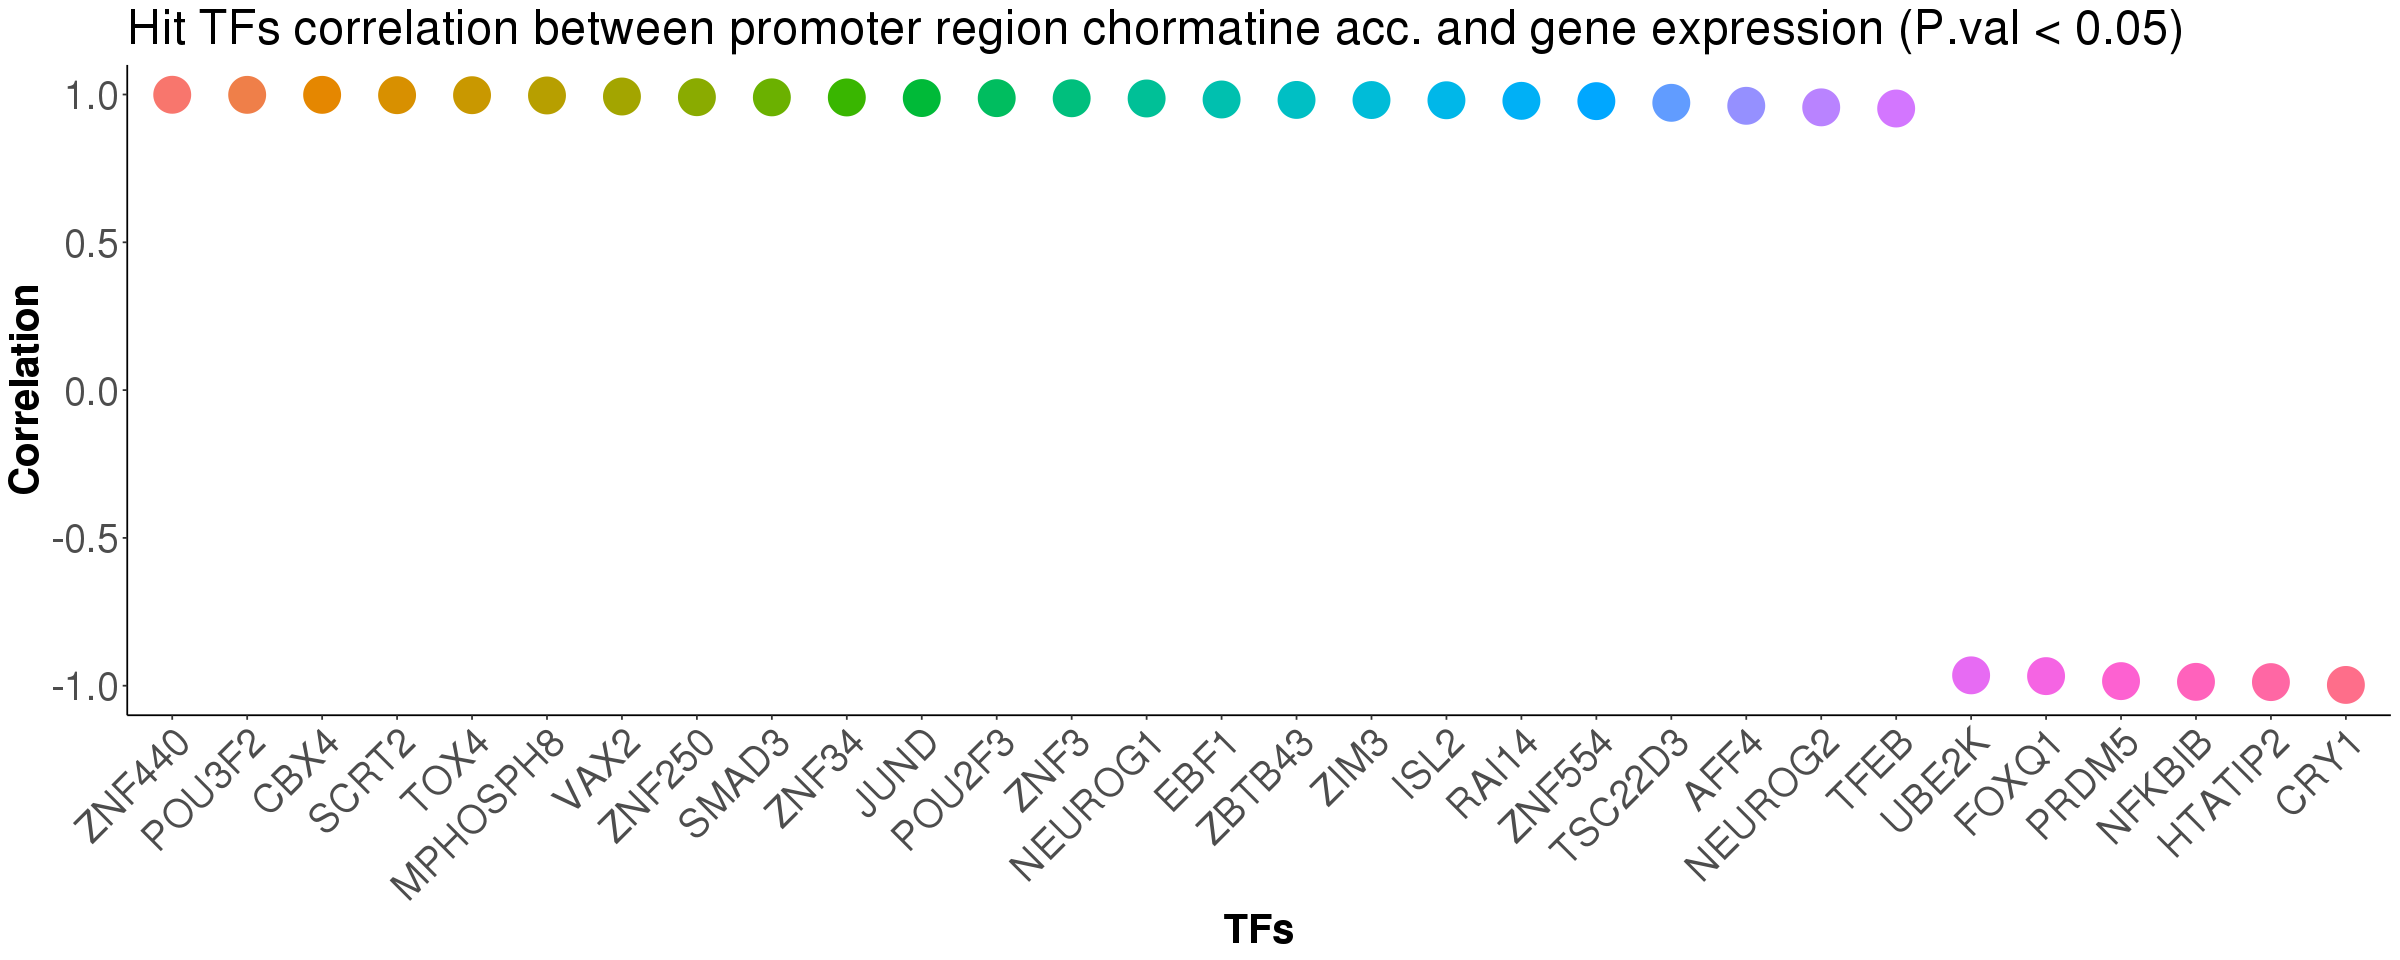

In [104]:
rna_atac.corrDF %>% select(gene:cor.p) %>%
    filter(cor.p < 0.05 & isHit ) %>% 
    mutate_at("gene", ~ factor(.x, cor_tf_order1)) %>%
    ggplot() + geom_point(aes(x=gene, y=corr, color=gene), size=10) +
    ylim(c(-1,1)) +
    theme_classic() +
    xlab(label = "TFs") + ylab(label = "Correlation") +
    labs(title = "Hit TFs correlation between promoter region chormatine acc. and gene expression (P.val < 0.05)") +
    theme(axis.text=element_text(size=24), axis.title=element_text(size=24,face="bold"), axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none", title=element_text(size=24)) 

In [105]:
rna_atac.corrDF %>% head

gene,isTF,isHit,corr,cor.p,CPM_rna_ES,CPM_rna_H16,CPM_rna_D1,CPM_rna_D4,CPM_atac_ES,CPM_atac_H16,CPM_atac_D1,CPM_atac_D4
<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABL1,TRUE,FALSE,0.9132862,0.086713820,115.626099,174.766887,136.417162,231.342997,32.57905,40.33014,41.91591,51.67339
ABT1,TRUE,FALSE,-0.8822787,0.117721254,204.800289,224.413458,261.673652,157.517824,17.80647,15.70469,16.17749,27.30332
ABTB1,TRUE,FALSE,-0.3027529,0.697247084,6.578397,7.404068,5.623486,6.012173,33.67076,29.35196,29.40128,40.88977
ADNP,TRUE,FALSE,0.9916090,0.008391042,459.249478,469.757908,467.953612,602.793683,31.45389,29.72952,32.72525,56.81693
ADNP2,TRUE,FALSE,-0.8785125,0.121487500,448.340702,346.594968,512.755583,201.272873,21.13896,20.39415,19.66218,32.58386
AEBP1,TRUE,FALSE,0.7979138,0.202086157,103.647879,32.116767,75.392202,4.241492,31.10841,19.54965,21.39076,20.48394


In [106]:
rna_atac.corrDF.set1a <- rna_atac.corrDF  %>%
                            filter(cor.p < 0.05 & isHit & corr < 0 ) %>% 
                            mutate_at("gene", ~ factor(.x, cor_tf_order1)) %>%
                            select(gene, CPM_rna_ES:CPM_rna_D4) %>%
                            pivot_longer(cols = CPM_rna_ES:CPM_rna_D4, names_to = "time", names_pattern = "CPM_rna_(.+)", values_to = "rna")
rna_atac.corrDF.set1b <- rna_atac.corrDF  %>%
                            filter(cor.p < 0.05 & isHit & corr < 0 ) %>% 
                            mutate_at("gene", ~ factor(.x, cor_tf_order1)) %>%
                            select(gene, CPM_atac_ES:CPM_atac_D4) %>%
                            pivot_longer(cols = CPM_atac_ES:CPM_atac_D4, names_to = "time", names_pattern = "CPM_atac_(.+)", values_to = "atac")

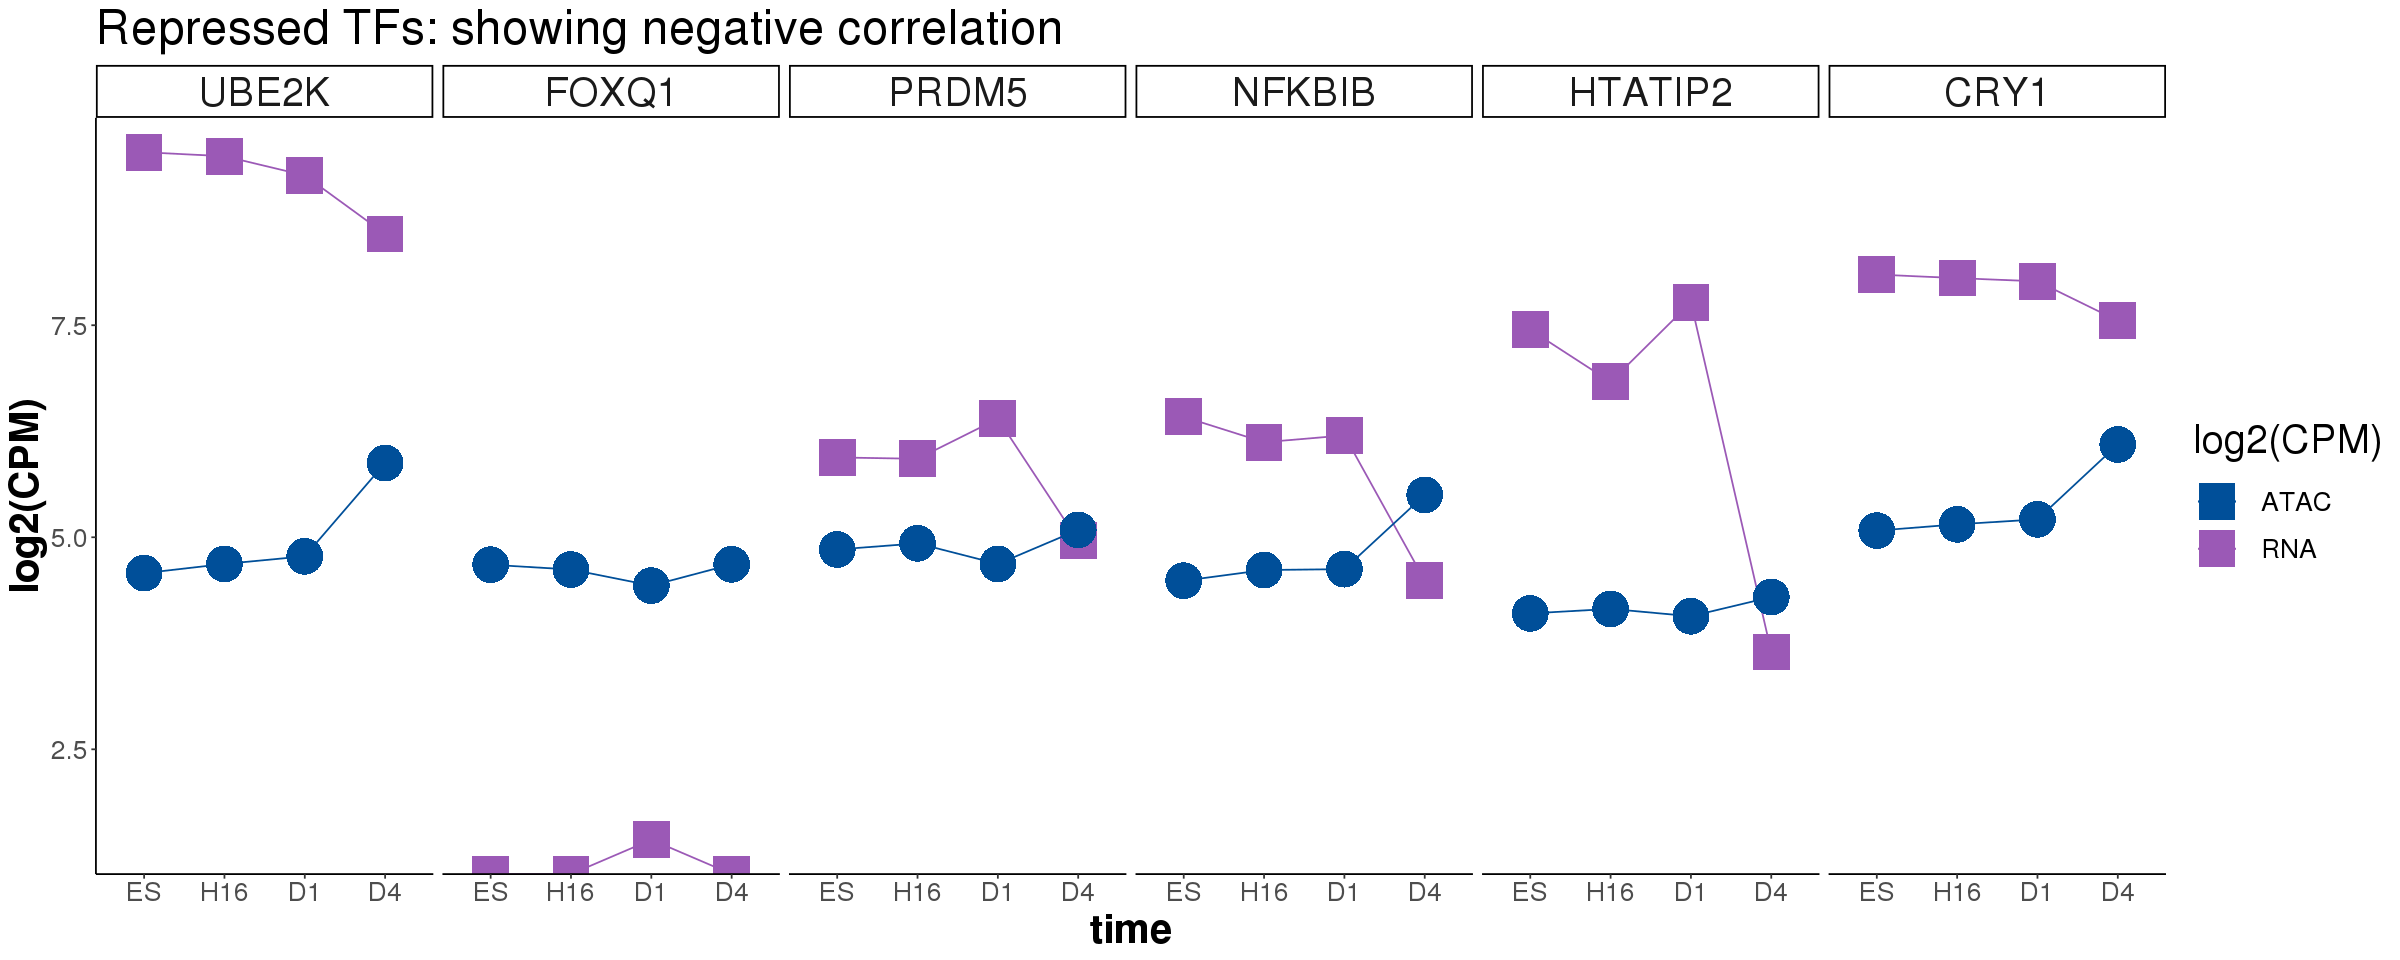

In [109]:
cols <- c("RNA"=flatui[1],"ATAC"=flatui[3])
inner_join(rna_atac.corrDF.set1a, rna_atac.corrDF.set1b, by = c("gene","time")) %>% 
    mutate_at("time", ~ factor(.x, levels=c("ES","H16","D1","D4"))) %>%
    ggplot() + 
        geom_point(aes(x=time, y=log2(rna), color = "RNA"), size=10, shape=15) + 
        geom_line(aes(x=time, y=log2(rna), group=gene, color = "RNA")) + 
        geom_point(aes(x=time, y=log2(atac), color = "ATAC"), size=10, shape=16) + 
        geom_line(aes(x=time, y=log2(atac), group=gene, color = "ATAC")) + 
        theme_classic() + 
        xlab(label = "time") + ylab(label = "log2(CPM)") +
        labs(title = "Repressed TFs: showing negative correlation") +
        scale_colour_manual(name="log2(CPM)",values=cols, guide = guide_legend(fill = NULL,colour = NULL)) +
        theme(axis.text=element_text(size=16), axis.title=element_text(size=24,face="bold"), 
          legend.text=element_text(size=16),legend.title=element_text(size=24), title=element_text(size=24), strip.text.x = element_text(size=24)) +
    facet_wrap(~gene, nrow=1)

In [110]:
targets <- c("E2F1" ,  "EBF1" ,  "JUND"  , "POU3F2", "ZBTB18" ,"SNAI2", "NEUROG2")

In [111]:
targets.set1a  <- filter(rna_atac.corrDF, isHit & gene %in% targets) %>% 
                            mutate_at("gene", ~ factor(.x, cor_tf_order1)) %>%
                            select(gene, CPM_rna_ES:CPM_rna_D4) %>%
                            pivot_longer(cols = CPM_rna_ES:CPM_rna_D4, names_to = "time", names_pattern = "CPM_rna_(.+)", values_to = "rna")
targets.set1b  <- filter(rna_atac.corrDF, isHit & gene %in% targets) %>% 
                            mutate_at("gene", ~ factor(.x, cor_tf_order1)) %>%
                            select(gene, CPM_atac_ES:CPM_atac_D4) %>%
                            pivot_longer(cols = CPM_atac_ES:CPM_atac_D4, names_to = "time", names_pattern = "CPM_atac_(.+)", values_to = "atac")

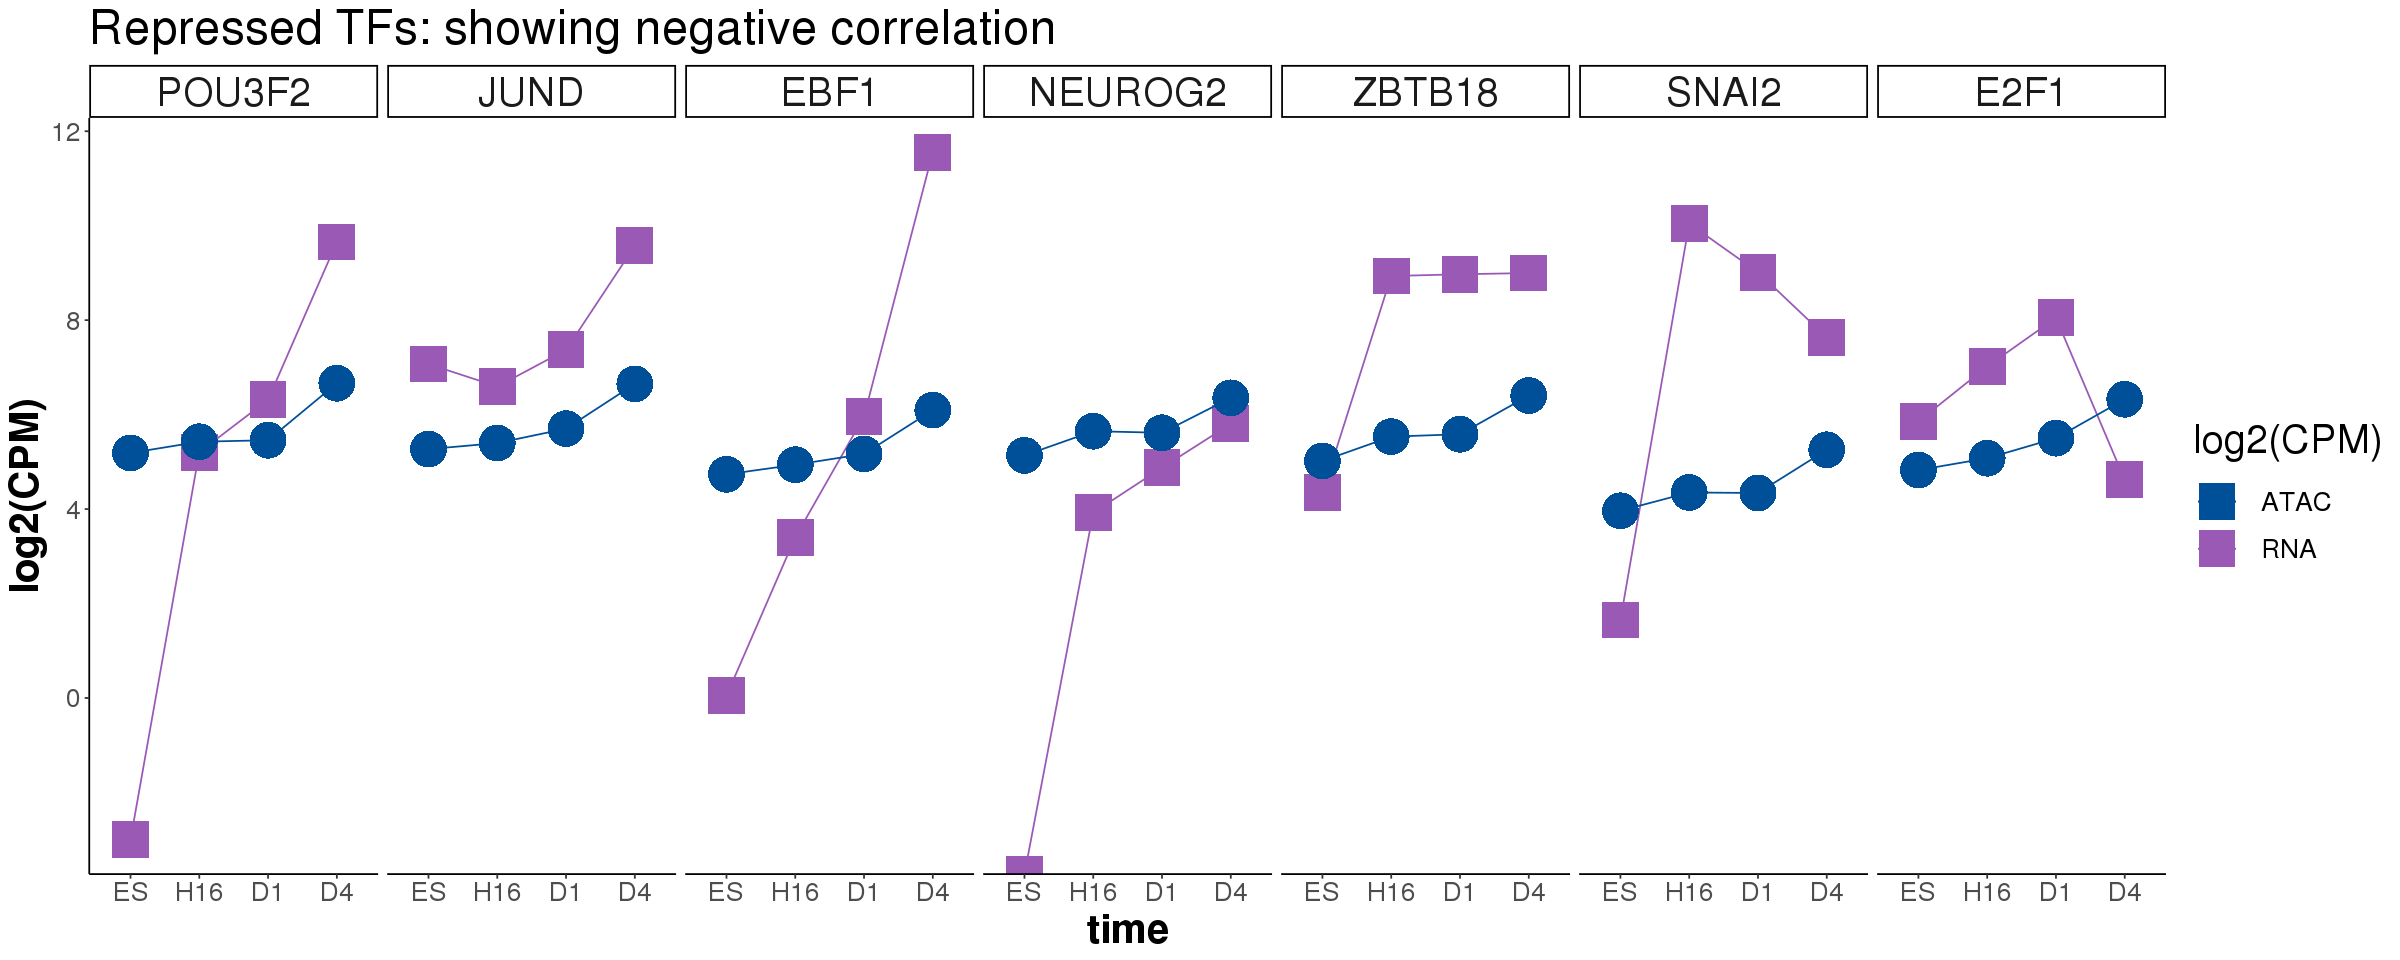

In [112]:
cols <- c("RNA"=flatui[1],"ATAC"=flatui[3])
inner_join(targets.set1a, targets.set1b, by = c("gene","time")) %>% 
    mutate_at("time", ~ factor(.x, levels=c("ES","H16","D1","D4"))) %>%
    ggplot() + 
        geom_point(aes(x=time, y=log2(rna), color = "RNA"), size=10, shape=15) + 
        geom_line(aes(x=time, y=log2(rna), group=gene, color = "RNA")) + 
        geom_point(aes(x=time, y=log2(atac), color = "ATAC"), size=10, shape=16) + 
        geom_line(aes(x=time, y=log2(atac), group=gene, color = "ATAC")) + 
        theme_classic() + 
        xlab(label = "time") + ylab(label = "log2(CPM)") +
        labs(title = "Repressed TFs: showing negative correlation") +
        scale_colour_manual(name="log2(CPM)",values=cols, guide = guide_legend(fill = NULL,colour = NULL)) +
        theme(axis.text=element_text(size=16), axis.title=element_text(size=24,face="bold"), 
          legend.text=element_text(size=16),legend.title=element_text(size=24), title=element_text(size=24), strip.text.x=element_text(size=24)) +
    facet_wrap(~gene, nrow=1)

In [113]:
filter(rna_atac.corrDF, cor.p < 0.05 & isHit & corr > 0 ) %>% top_n(6,corr)

gene,isTF,isHit,corr,cor.p,CPM_rna_ES,CPM_rna_H16,CPM_rna_D1,CPM_rna_D4,CPM_atac_ES,CPM_atac_H16,CPM_atac_D1,CPM_atac_D4
<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CBX4,TRUE,TRUE,0.9987708,0.0012292016,4.6182442,9.366095,4.596194,116.75187,23.427213,23.88543,24.20708,43.39161
MPHOSPH8,TRUE,TRUE,0.9966987,0.0033012931,170.3847939,137.411441,172.474245,370.49292,21.536185,18.11089,21.79637,68.24269
POU3F2,TRUE,TRUE,0.9987759,0.0012241404,0.1249526,36.863184,79.624025,806.04275,36.474514,42.97323,43.94399,101.40202
SCRT2,TRUE,TRUE,0.9976775,0.0023225461,0.0000000,0.000000,2.976901,141.25474,21.433867,21.19405,20.46104,38.05825
TOX4,TRUE,TRUE,0.9976154,0.0023845755,136.4034650,137.016545,142.627025,282.98017,22.344459,23.33174,22.35176,44.08772
ZNF440,TRUE,TRUE,0.9990493,0.0009507405,2.3190134,9.898443,4.301062,25.31839,9.056136,10.64927,9.60434,13.44034


In [115]:
rna_atac.corrDF.set2a <- rna_atac.corrDF  %>%
                            filter(cor.p < 0.05 & isHit & corr > 0 ) %>%  top_n(6,corr) %>%
                            mutate_at("gene", ~ factor(.x, cor_tf_order1)) %>%
                            select(gene, CPM_rna_ES:CPM_rna_D4) %>%
                            pivot_longer(cols = CPM_rna_ES:CPM_rna_D4, names_to = "time", names_pattern = "CPM_rna_(.+)", values_to = "rna")
rna_atac.corrDF.set2b <- rna_atac.corrDF  %>% 
                            filter(cor.p < 0.05 & isHit & corr > 0 ) %>%  top_n(6,corr) %>%
                            mutate_at("gene", ~ factor(.x, cor_tf_order1)) %>%
                            select(gene, CPM_atac_ES:CPM_atac_D4) %>%
                            pivot_longer(cols = CPM_atac_ES:CPM_atac_D4, names_to = "time", names_pattern = "CPM_atac_(.+)", values_to = "atac")

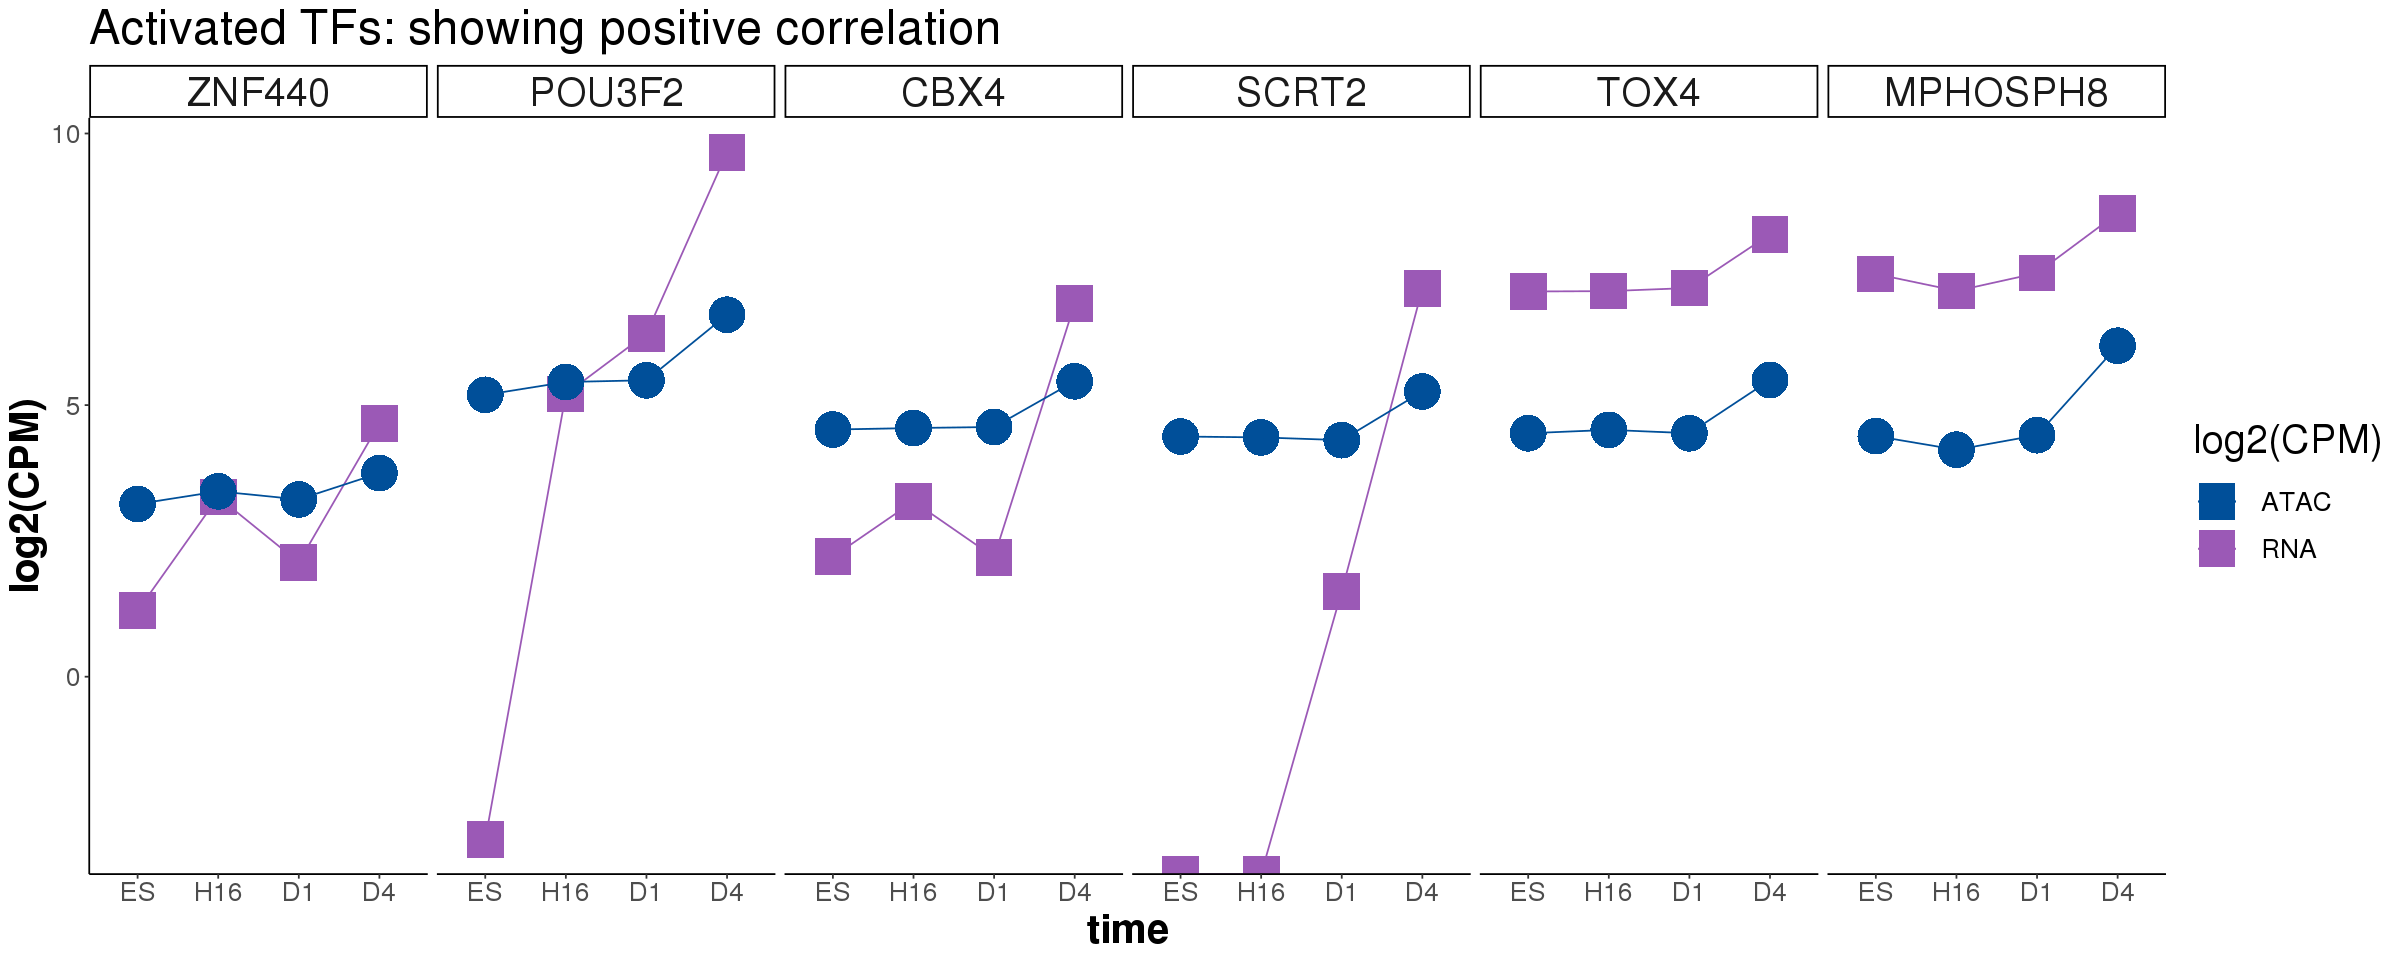

In [116]:
cols <- c("RNA"=flatui[1],"ATAC"=flatui[3])
inner_join(rna_atac.corrDF.set2a, rna_atac.corrDF.set2b, by = c("gene","time")) %>%
    mutate_at("time", ~ factor(.x, levels=c("ES","H16","D1","D4"))) %>%
    ggplot() + 
        geom_point(aes(x=time, y=log2(rna), color = "RNA"), size=10, shape=15) + 
        geom_line(aes(x=time, y=log2(rna), group=gene, color = "RNA")) + 
        geom_point(aes(x=time, y=log2(atac), color = "ATAC"), size=10, shape=16) + 
        geom_line(aes(x=time, y=log2(atac), group=gene, color = "ATAC")) + 
        theme_classic() + 
        xlab(label = "time") + ylab(label = "log2(CPM)") +
        labs(title = "Activated TFs: showing positive correlation") +
        scale_colour_manual(name="log2(CPM)",values=cols, guide = guide_legend(fill = NULL,colour = NULL)) +
        theme(axis.text=element_text(size=16), axis.title=element_text(size=24,face="bold"), 
          legend.text=element_text(size=16),legend.title=element_text(size=24), title=element_text(size=24), strip.text.x=element_text(size=24)) +
    facet_wrap(~gene, nrow=1)

#### validated hits

In [570]:
validated.hits <- c("ZBTB18", "ZZZ3", "ARID1B", "ZNF311")

#### ChromVAR results

In [587]:
suppressMessages(chromvarDF <- read_csv("../chromVAR_jaspar2020_zScore.csv"))

In [595]:
library(pheatmap)

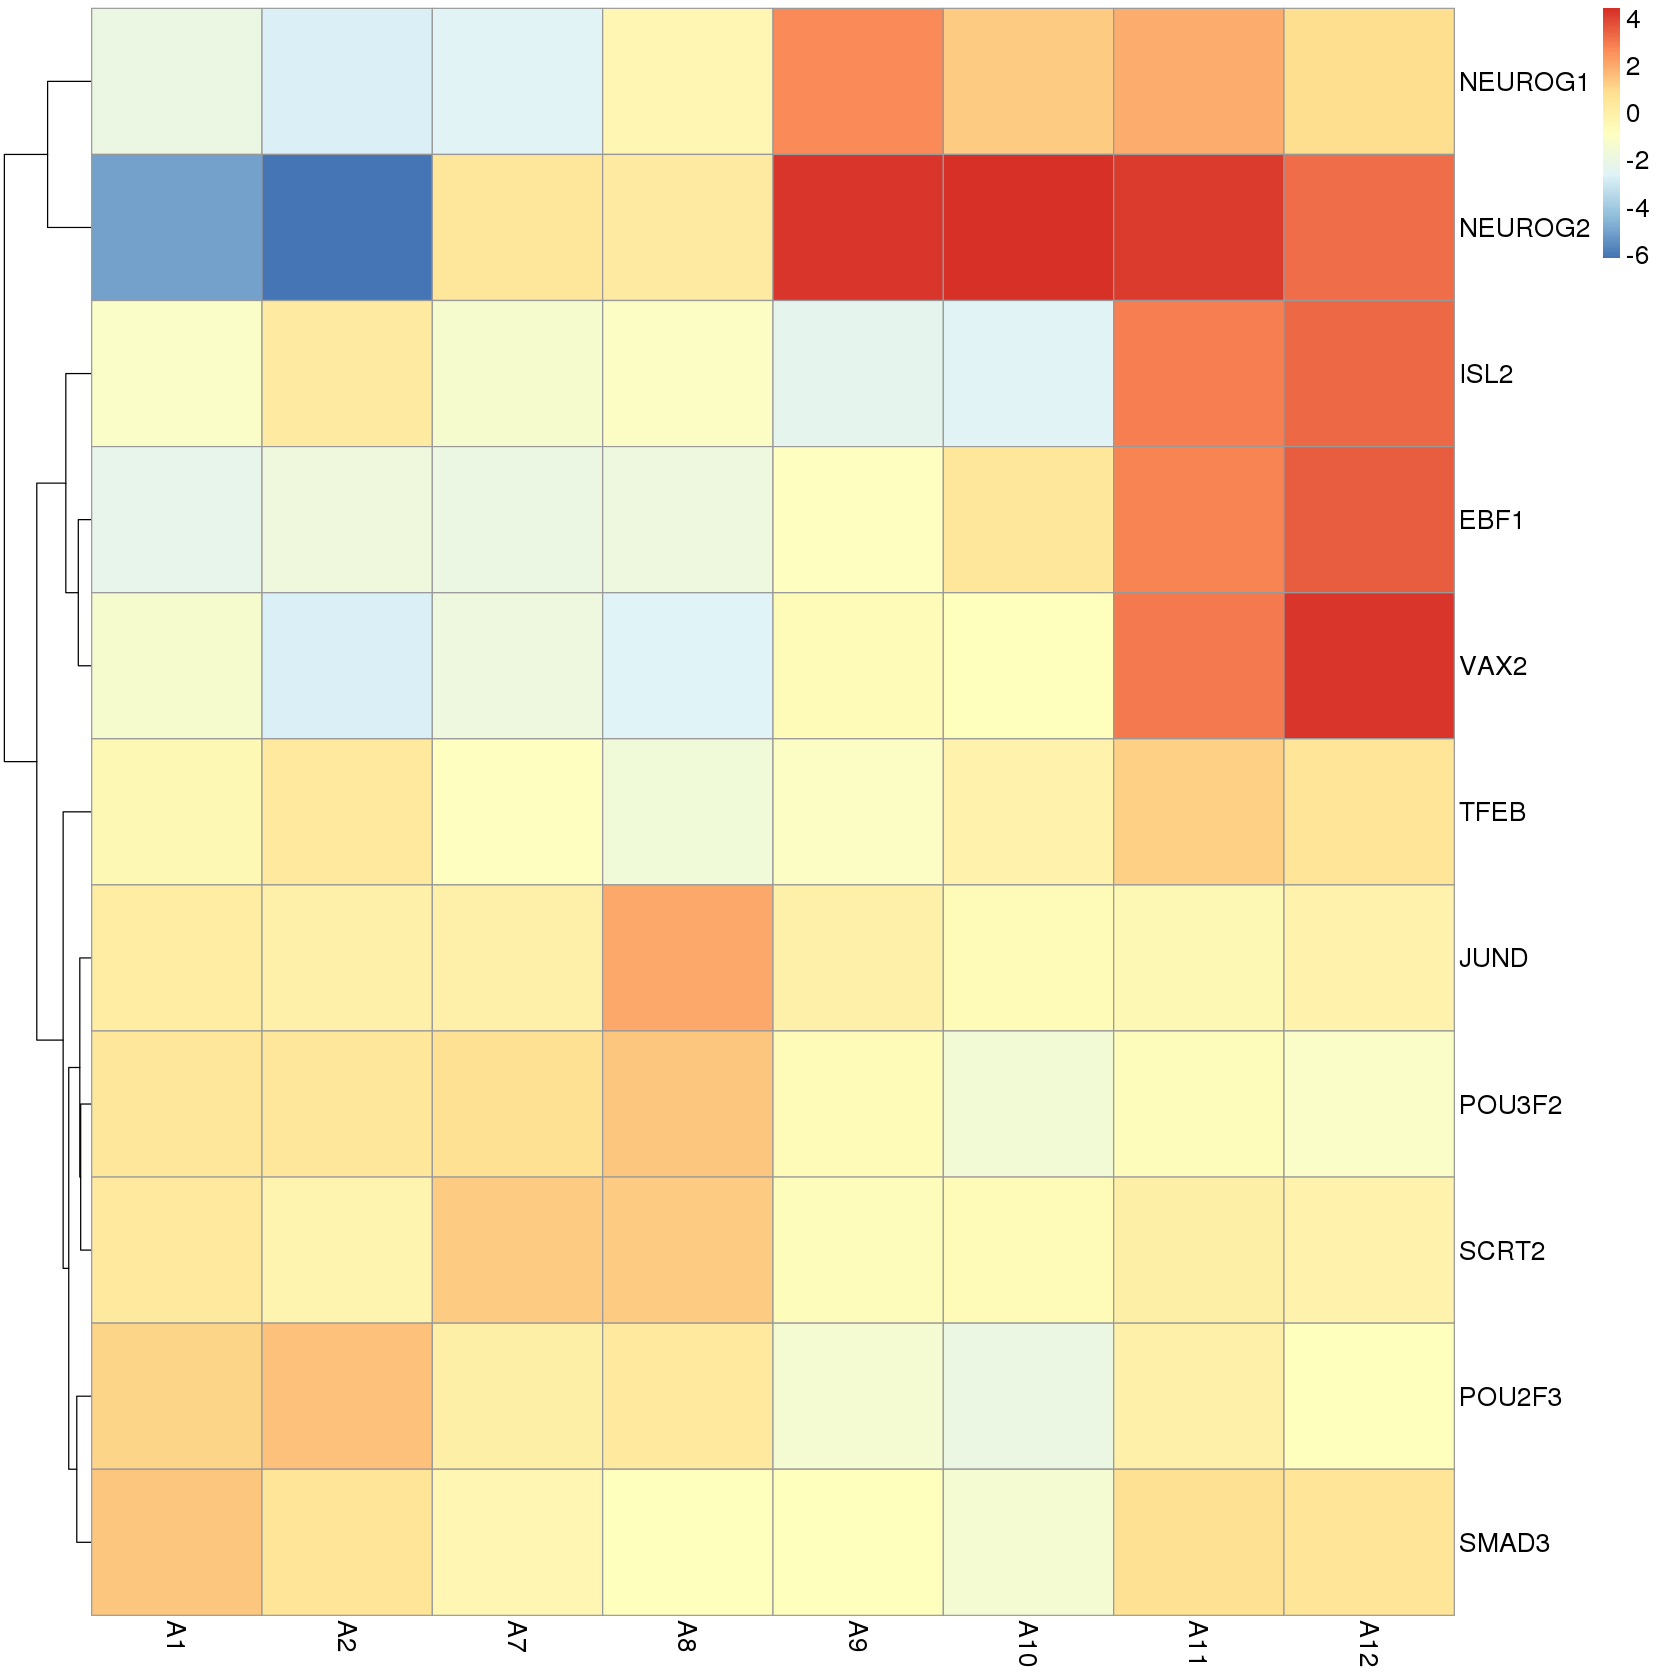

In [597]:
chromvarDF %>% filter(gene_name %in% corr.hit.tf) %>% 
    select(gene_name, A1:A2, A7:A12) %>%
    column_to_rownames("gene_name") %>% 
    pheatmap(cluster_cols = F, cluster_rows = T, fontsize = 16)